In [1]:
library(Seurat)
library(tidyverse)
library(doParallel)
library(patchwork)

library(ggplot2)
library(forcats) # 和 ggplot 一起给数据排序
library(ggrepel)
library(viridis)
library(ggpubr)
library(ggprism)
library(reshape)
library(ggalluvial)
library(ggthemes)
library(scales)

Attaching SeuratObject

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Warning message:
“package ‘iterators’ was built under R version 4.1.2”
Loading required package: parallel

Loading required package: viridisLite


Attaching package: ‘reshape’


The following object is masked from ‘package:lubridate’:

    stamp


The following object 

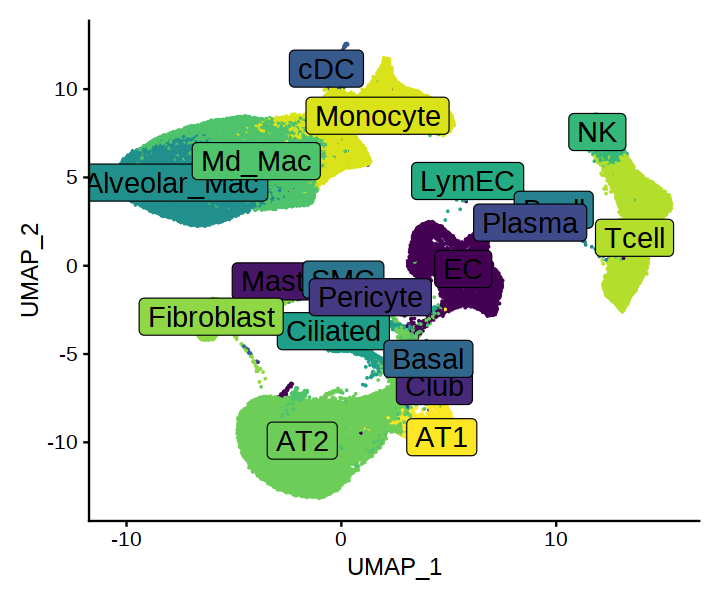

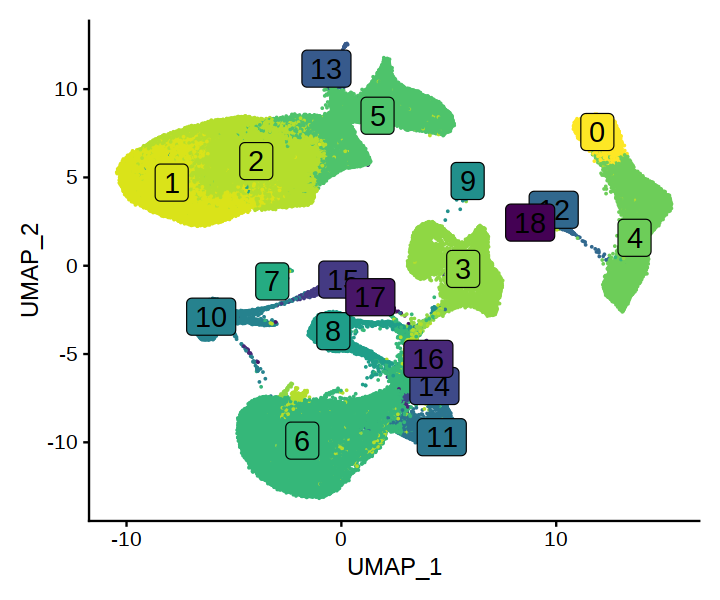

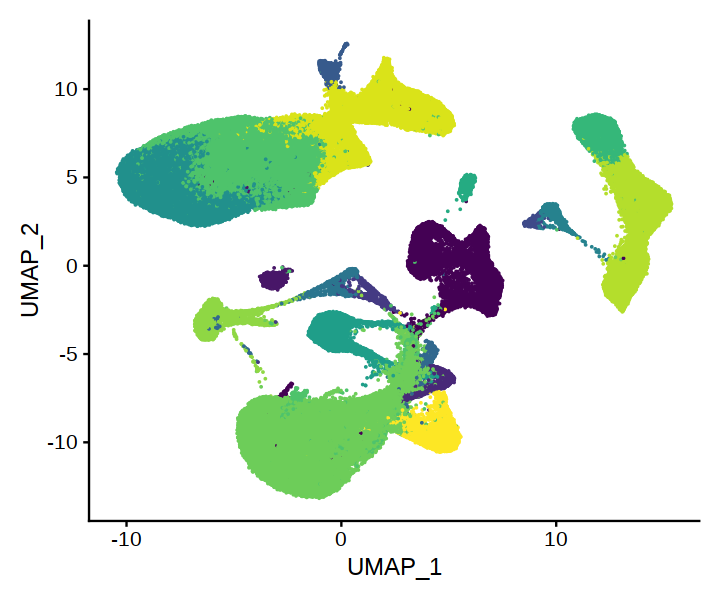

In [2]:
immune.cluster <- readRDS('ssc_lung_allCT.rds')
ct.list <- c('AT1', 'Monocyte', 'Tcell', 'Fibroblast', 
            'AT2', 'Md_Mac', 'NK', 'LymEC',
            'Ciliated', 'Alveolar_Mac', 'Bcell', 'SMC', 
            'Basal', 'cDC', 'Plasma', 'Pericyte',
            'Club',  'Mast', 'EC')
immune.cluster@meta.data$CellType <- factor(immune.cluster@meta.data$CellType, levels = ct.list)
options(repr.plot.height = 5, repr.plot.width = 6)
# pdf(file="./figures/Lung_CellType_label.pdf",width=7)
Idents(immune.cluster) <- 'CellType'
DimPlot(immune.cluster, reduction = "umap", label = TRUE, label.size = 6, label.box = TRUE, raster = FALSE, cols=rev(viridis_pal()(19))) + NoLegend()
# dev.off()
Idents(immune.cluster) <- 'celltype.res.0.1'
DimPlot(immune.cluster, reduction = "umap", label = TRUE, label.size = 6, label.box = TRUE, raster = FALSE, cols=rev(viridis_pal()(19))) + NoLegend()
# pdf(file="./figures/Lung_CellType.pdf",width=7)
Idents(immune.cluster) <- 'CellType'
DimPlot(immune.cluster, reduction = "umap", label = FALSE, label.size = 6, label.box = TRUE, raster = FALSE, cols=rev(viridis_pal()(19))) + NoLegend()
# dev.off()

In [3]:
# Count the number of celltype we identified
immune.cluster@meta.data$CellType %>% unique()
immune.cluster@meta.data$ct_level2 %>% unique() %>% length()
immune.cluster@meta.data$ct_level2 %>% unique()  # 43

[1] NK           Alveolar_Mac Md_Mac       EC           Tcell       
 [6] Monocyte     AT2          Mast         Ciliated     LymEC       
[11] Fibroblast   AT1          Bcell        cDC          Club        
[16] SMC          Basal        Pericyte     Plasma      
19 Levels: AT1 Monocyte Tcell Fibroblast AT2 Md_Mac NK LymEC ... EC

[1] 43

[1] "CD8_Tem"                  "Mac_PPARG"               
 [3] "Mac_SPP1"                 "Mac_CCL2"                
 [5] ""                         "CD8_Temra"               
 [7] "NK"                       "Mast"                    
 [9] "Ciliated"                 "CD4_Tem"                 
[11] "Mac_LYVE1"                "Mac_GPR183"              
[13] "Treg"                     "LymphEC"                 
[15] "CD4_Tna"                  "AT2"                     
[17] "AT2_AT1"                  "Mono_CD14"               
[19] "Mono_CD16"                "Bm_IGHM+"                
[21] "cDC"                      "Club"                    
[23] "Basal"                    "Bm_IGHM-"                
[25] "TRB-SCs"                  "Bmn_IGHD"                
[27] "Plasma_PRDM1"             "artery"                  
[29] "Alveolar capillary"       "quiescent"               
[31] "Smooth_muscle"            "extra-alveolar capillary"
[33] "Fib_SPINT2"               "Pericyte"                
[35] "vein"                     "Fib_POSTN"               
[37] "Post-capillary venule"    "immature"                
[39] "Fib_PI16"                 "Fib_MYH11"               
[41] "AT1"                      "preTB-SC"                
[43] "Plasma_CCL2"

In [15]:
# --- Extract sample information
meta <- immune.cluster@meta.data
meta[,c('SamNum', 'SampleID', 'Group', 'Site', 'Gender', 'Age', 'Cohort')] %>% distinct() %>% {rownames(.) <- NULL; {.}} %>%
write.csv('lung_sample_info.csv')

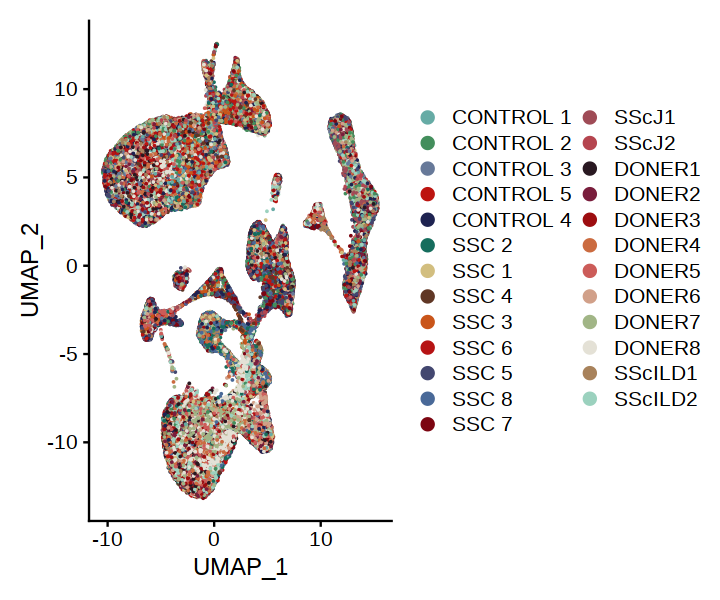

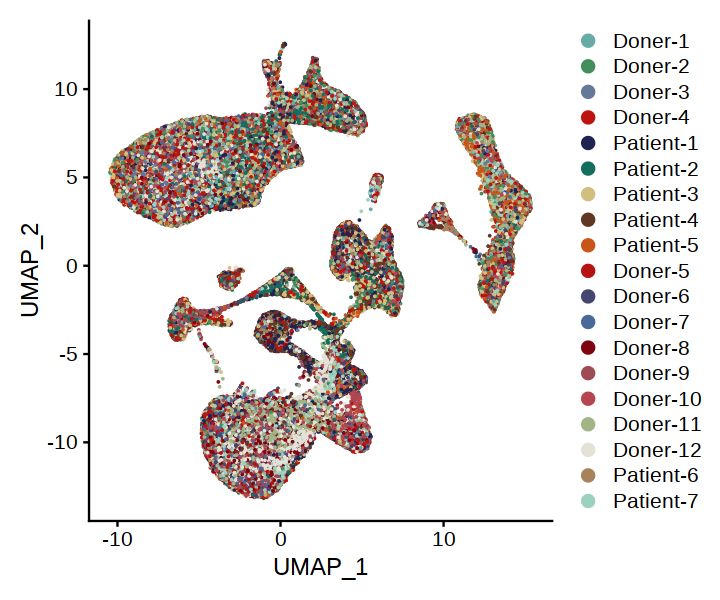

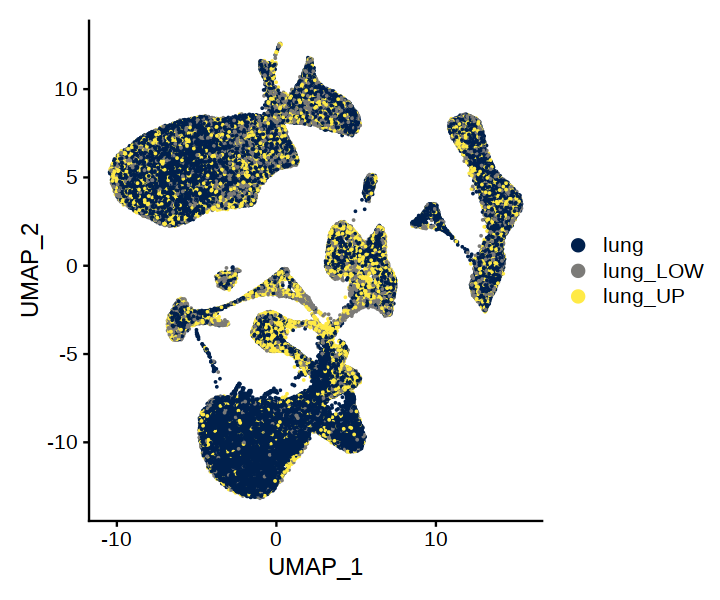

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



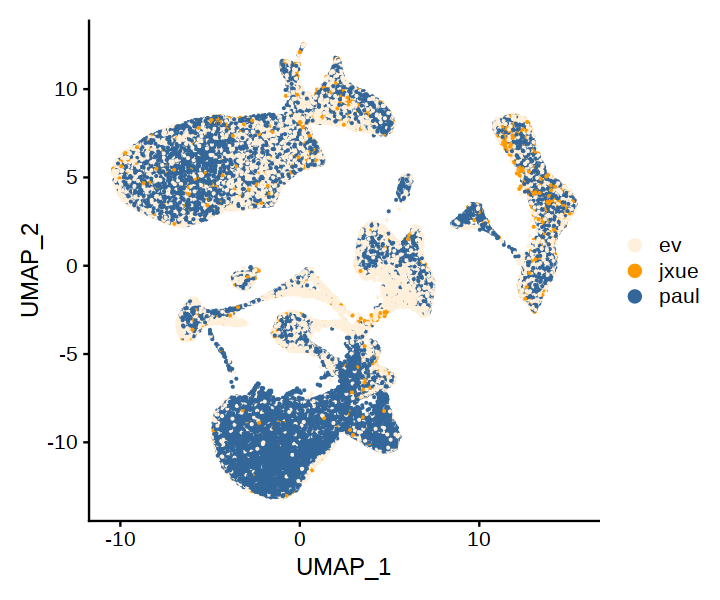

ERROR: Error in Idents(immune.health) <- "CellType": object 'immune.health' not found


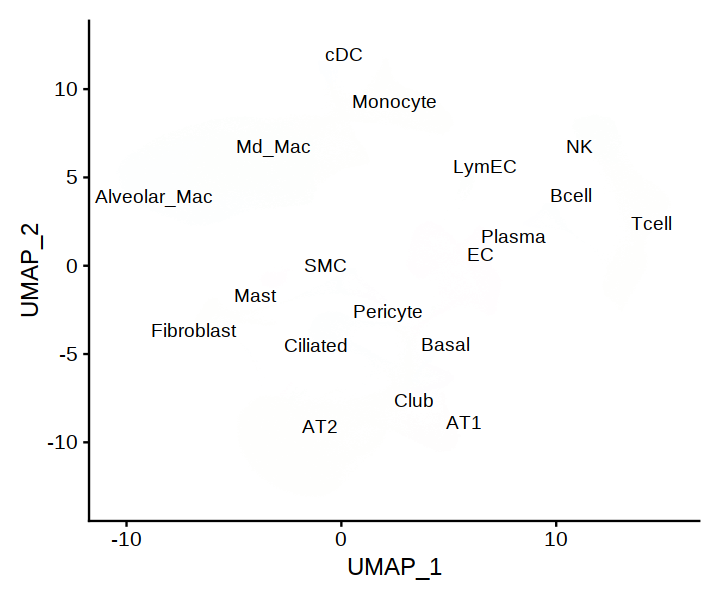

In [4]:
# --- CCA quality control
sam.col <- c( '#66ABA5',  '#438E5C',  '#677999',  '#BD1410',  '#1E2351',  '#156D5D', 
             '#D2BE7F',  '#603725',  '#C9551A',  '#B61314',  '#434770',  '#496998', 
             '#7C0511',  '#9F4B56',  '#B5454F',  '#291821',  '#791D3C',  '#9D0D10', 
             '#CB6B40',  '#CC5C59',  '#D1A089',  '#A1B586',  '#E4E1D6',  '#A8825B',  '#9BD1BE')
# pdf(file="./figures/sample_umap.pdf", width=10)
Idents(immune.cluster) <- "SampleID"
DimPlot(immune.cluster, reduction = "umap",label = FALSE,label.size=4,raster = FALSE,label.box=FALSE,repel=TRUE, shuffle=TRUE, cols=sam.col, pt.size = 0.01)
# dev.off()

p.col <- c( '#66ABA5',  '#438E5C',  '#677999',  '#BD1410',  '#1E2351', 
           '#156D5D', '#D2BE7F',  '#603725',  '#C9551A',  '#B61314', 
           '#434770',  '#496998', '#7C0511',  '#9F4B56',  '#B5454F',  
           '#A1B586',  '#E4E1D6',  '#A8825B',  '#9BD1BE')
# pdf(file="./figures/Patient_umap.pdf", width=8)
Idents(immune.cluster) <- "PatientID"
DimPlot(immune.cluster, reduction = "umap",label = FALSE,label.size=4,raster = FALSE,label.box=FALSE,repel=TRUE, shuffle=TRUE, cols = p.col)
# dev.off()

# pdf(file="./figures/Tissue_umap.pdf", width=8)
Idents(immune.cluster) <- "Tissue"
DimPlot(immune.cluster, reduction = "umap",label = FALSE,label.size=4,raster = FALSE,label.box=FALSE,repel=TRUE, shuffle=TRUE, cols=(viridis(3, option = "E")))
# dev.off()

# pdf(file="./figures/Cohort_umap.pdf", width=8)
Idents(immune.cluster) <- "Cohort"
DimPlot(immune.cluster, reduction = "umap",label = FALSE, pt.size=0.1, raster = FALSE,label.box=FALSE,repel=TRUE, shuffle=TRUE, cols=c('#FFF0DC', '#FF9900', '#336699'))
# dev.off()

# pdf(file="/share/home/qlab/projects/qlab_yrs/project_ssc/result/Umap/SSC_Combine/all_umap.pdf")
Idents(immune.cluster) <- "CellType"
DimPlot(immune.cluster, reduction = "umap",label = TRUE,label.size=4,label.box=FALSE,repel=TRUE,shuffle=TRUE) + NoLegend()
# dev.off()

# pdf(file="/share/home/qlab/projects/qlab_yrs/project_ssc/result/Umap/SSC_Combine/health_umap.pdf")
Idents(immune.health) <- "CellType"
DimPlot(immune.health, reduction = "umap",label = TRUE,label.size=4,label.box=FALSE,repel=TRUE,shuffle=TRUE) + NoLegend()
# dev.off()

# pdf(file="/share/home/qlab/projects/qlab_yrs/project_ssc/result/Umap/SSC_Combine/ssc_umap.pdf")
Idents(immune.ssc) <- "CellType"
DimPlot(immune.ssc, reduction = "umap",label.size=4,label=TRUE,label.box=FALSE,repel=TRUE,shuffle=TRUE) + NoLegend()
# dev.off()

# pdf(file="/share/home/qlab/projects/qlab_yrs/project_ssc/result/Umap/SSC_Combine/ssc_group_umap.pdf")
Idents(immune.cluster) <- "Group"
DimPlot(immune.cluster, reduction = "umap",label.size=4,label=FALSE,label.box=FALSE,repel=TRUE,shuffle=TRUE)
# dev.off()

# pdf('./cohort_umap.pdf')
DimPlot(immune.cluster, dims = c(1, 2), cells = NULL,
  cols = viridis(3, option = "D"), pt.size = NULL, reduction = 'umap',  group.by = 'Cohort',
  split.by = NULL, shape.by = NULL,  order = NULL, shuffle = FALSE, seed = 1, 
  label = FALSE, label.size = 4, label.color = "black",  label.box = TRUE, 
  repel = TRUE, cells.highlight = NULL, cols.highlight = "#DE2D26", sizes.highlight = 1,
  na.value = "grey50",  ncol = NULL,  combine = TRUE,  raster = TRUE,  raster.dpi = c(512, 512)
)
# dev.off()

In [383]:
# # --- Export sequence data
# write.csv(
#     immune.cluster@meta.data[,c('nCount_RNA', 'nFeature_RNA', 'CellType')] %>% 
#     group_by(CellType) %>% summarise(Cells = n(), Average_UMIs = mean(nCount_RNA), Average_Genes = mean(nFeature_RNA)),
#     'celltype_statistic.csv')
# write.csv(
#     immune.cluster@meta.data[,c('nCount_RNA', 'nFeature_RNA', 'SampleID')] %>% 
#     group_by(SampleID) %>% summarise(Cells = n(), Average_UMIs = mean(nCount_RNA), Average_Genes = mean(nFeature_RNA)),
#     'sample_statistic.csv')

In [5]:
# # --- Top Genes/TFs for each cluster
# immune.cluster.l3 <- immune.cluster %>% subset(Cohort != 'jxue')
# DefaultAssay(immune.cluster.l3) <- 'RNA'
# Idents(immune.cluster.l3) <- 'CellType'
# top.genes <- FindAllMarkers(immune.cluster.l3, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

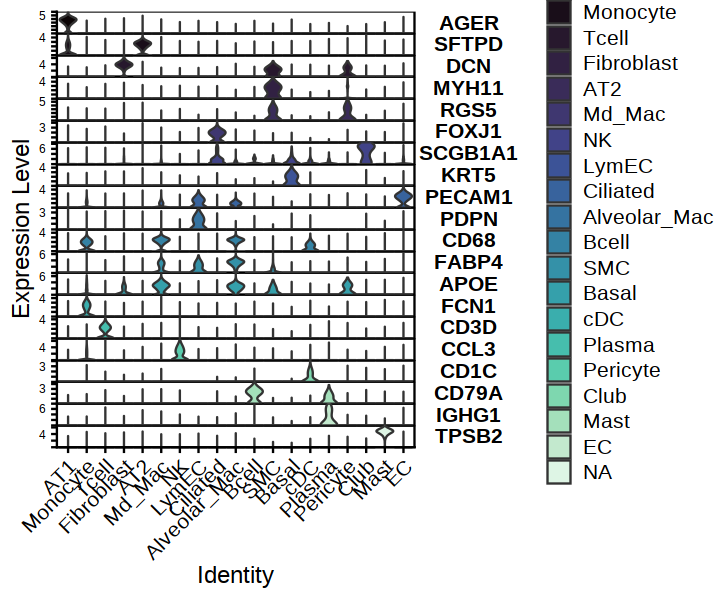

In [7]:
# --- Features Plots
immune.cluster.filter <- subset(immune.cluster, CellType!='Low_Quality')
DefaultAssay(immune.cluster) <- 'RNA'

# pdf(file='./figures/Features.pdf',width=8)
VlnPlot(immune.cluster, features = c("AGER","SFTPD","DCN","MYH11","RGS5","FOXJ1","SCGB1A1","KRT5","PECAM1",
                                     "PDPN","CD68","FABP4","APOE","FCN1",
                                     "CD3D","CCL3","CD1C","CD79A","IGHG1","TPSB2"), 
        slot = "data",stack=TRUE, flip = T, adjust = 2, group.by = 'CellType',cols = viridis(20, option = "G"))
# dev.off()

`summarise()` has grouped output by 'SampleID'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'SampleID', 'Group'. You can override using
the `.groups` argument.


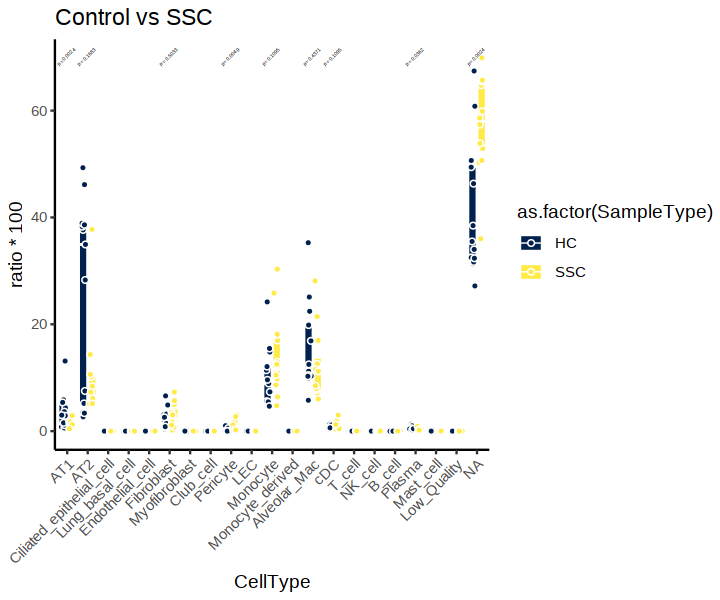

In [13]:
# --- CellProp Comparing
order.list <- c('AT1','AT2','Ciliated_epithelial_cell', 'Lung_basal_cell',
                'Endothelial_cell','Fibroblast','Myofibroblast','Club_cell', 'Pericyte','LEC',
               'Monocyte','Monocyte_derived','Alveolar_Mac','cDC',
                'T_cell','NK_cell', 'B_cell','Plasma','Mast_cell','Low_Quality')

immune.cluster.order <- immune.cluster
immune.cluster.order@meta.data$CellType <- factor(immune.cluster.order@meta.data$CellType, levels = order.list)
classifier  <- "Group"
metadata.df  <- immune.cluster.order@meta.data %>%
  tibble::rownames_to_column(var = "Cell")
cell_num.df  <- metadata.df %>%
  dplyr::group_by(SampleID, !!sym(classifier)) %>%
  dplyr::summarise(total = n()) %>%
  dplyr::ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  dplyr::mutate(ID = paste0(SampleID,".",SampleType)) %>%
  dplyr::select(ID,total)

ratio.df  <- metadata.df %>%
  dplyr::group_by(SampleID,!!sym(classifier), CellType) %>% #
  dplyr::summarise(sum = n()) %>%
  ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  tidyr::complete(nesting(SampleID, SampleType), CellType, fill = list(sum = 0)) %>% #
  dplyr::mutate(ID = paste0(SampleID,".",SampleType)) %>%
  left_join(cell_num.df, by = "ID") %>%
  rowwise() %>%
  dplyr::mutate(ratio = sum / total )

# colors.use  <- scales::viridis_pal()(3)[1:2]
colors.use  <- viridis(2, option = "E")

# ratio.df$CellType  <- factor(ratio.df$CellType, levels = plot.order)
ratio.df$SampleType  <- factor(ratio.df$SampleType, levels = c("HC","SSC"))

# fig.size(18,20)
library(ggpubr)
ggplot(ratio.df,aes(x = CellType, y = ratio * 100, fill = as.factor(SampleType))) + #
  geom_boxplot(outlier.shape = NA, position=position_dodge(width=0.9), size = 0.3, colour = "#FFFFFF") +
  geom_point(pch = 21, position = position_jitterdodge(), colour = "white", size = 1.25) +
  #   geom_jitter( size = 0.6 , position=position_dodge(width=0.9),aes(group=SampleType, alpha = 0.6)) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ggtitle("Control vs SSC") +
  scale_fill_manual(values = colors.use)+
  stat_compare_means(aes(label = paste0("p = ", ..p.format..)), angle = 45,size=1, method = "wilcox.test") 
# ggsave('./figures/ControlVsSSC_2.pdf',width=7,height=4)

In [14]:
# --- 01-Calculate the CellProp correlation in HC and SSC separately
library(Hmisc)
library(psych)
library(corrplot)
library(network)
library(ggnetwork)

immune <- immune.cluster %>% subset(ct_level2 != '')
# --- prepare the ratio data
classifier  <- "Group"
metadata.df <- immune@meta.data
cell_num.df  <- immune.cluster@meta.data %>%
  dplyr::group_by(SampleID, !!sym(classifier)) %>% # !!sym(classifier) 这句可将字符串的双引号去除掉
  dplyr::summarise(total = n()) %>%
  dplyr::ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  dplyr::mutate(ID = paste0(SampleID,".",SampleType)) %>%
  dplyr::select(ID,total)

ratio.df  <- metadata.df %>%
  dplyr::group_by(SampleID, !!sym(classifier), ct_level2) %>%
  dplyr::summarise(sum = n()) %>%
  ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  tidyr::complete(nesting(SampleID, SampleType), ct_level2, fill = list(sum = 0)) %>% 
  dplyr::mutate(ID = paste0(SampleID,".",SampleType)) %>%
  left_join(cell_num.df, by = "ID") %>%
  rowwise() %>%
  dplyr::mutate(ratio = sum / total )

hc.ratio <- ratio.df %>% as.data.frame() %>% dplyr::filter(SampleType == 'HC') %>% .[,c('SampleID', 'ct_level2', 'ratio')] %>% 
                pivot_wider(names_from = 'ct_level2', values_from = 'ratio', values_fill = 0) %>% column_to_rownames(var = 'SampleID')
hc.cor.pr = corr.test(hc.ratio[,1:41], hc.ratio[,1:41], method = 'pearson')

ssc.ratio <- ratio.df %>% as.data.frame() %>% dplyr::filter(SampleType == 'SSC') %>% .[,c('SampleID', 'ct_level2', 'ratio')] %>% 
                pivot_wider(names_from = 'ct_level2', values_from = 'ratio', values_fill = 0) %>% column_to_rownames(var = 'SampleID')
ssc.cor.pr = corr.test(ssc.ratio[,1:41], ssc.ratio[,1:41], method = 'pearson')

ct.meta <- immune@meta.data


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following object is masked from ‘package:SeuratObject’:

    Key


The following object is masked from ‘package:Seurat’:

    Key


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘psych’


The following object is masked from ‘package:Hmisc’:

    describe


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


corrplot 0.92 loaded


‘network’ 1.18.2 (2023-12-04), part of the Statnet Project
* ‘news(package="network")’ for changes since last version
* ‘citation("network")’ for citation information
* ‘https://statnet.org’ for help, support, and other information



Attaching package: ‘network’


The following object is masked from ‘package:Hmisc’:

    is.discrete


`summarise()` has grouped output by 'SampleID'. You can override

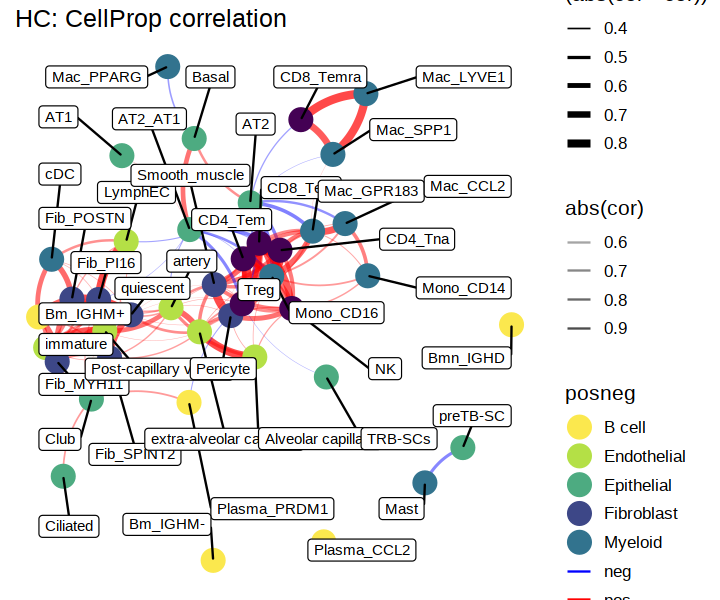

In [16]:
# --- 02-plot HC CellProp cor network
cor.df <- hc.cor.pr$r
p.df <- hc.cor.pr$p
n <- network(cor.df, directed = FALSE)
n %v% "ct_level1" <- colnames(p.df)
rename <- colnames(cor.df)
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Epithelial') %>% .$ct_level2 %>% unique())] <- 'Epithelial'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Endothelial') %>% .$ct_level2 %>% unique())] <- 'Endothelial'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Fibroblast') %>% .$ct_level2 %>% unique())] <- 'Fibroblast'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Myeloid') %>% .$ct_level2 %>% unique())] <- 'Myeloid'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Lymphocyte_B') %>% .$ct_level2 %>% unique())] <- 'B cell'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Lymphocyte_T/NK') %>% .$ct_level2 %>% unique())] <- 'T/NK cell'
n %v% "ct_level2" <- rename
e <- network.edgecount(n)

#cor.gcmec
cor.final <- NULL
for(i in 1: (ncol(cor.df)-1)){
    cor.data <- cor.df[,i][-(1:i)]
    cor.final <- c(cor.final, cor.data)
}

#p.gcmec
p.final <- NULL
for(i in 1: (ncol(p.df)-1)){
    p.data <- p.df[,i][-(1:i)]
    p.final <- c(p.final, p.data)
}
set.edge.attribute(n, "cor", cor.final)
set.edge.attribute(n, "p", p.final)
set.edge.attribute(n, 'posneg', ifelse(cor.final >0, 'pos', 'neg'))

all <- NULL
for(i in 1:e){
    if(n$ mel[[i]]$ atl$ p < 0.05){
        all <- c(all,i)
    }
}
n$ mel <- n$ mel[all]

set.seed(20)
# pdf('./figures/HC_CellProp_corr.pdf',width = 7.5, height  = 6)
ggplot(n, aes(x = x, y = y, xend = xend, yend = yend)) +
  geom_edges(aes(linewidth = (abs(cor*cor)),color = posneg, alpha = abs(cor)), curvature = 0.2) +
  geom_nodes(aes(colour = ct_level2),size = 6) +
  geom_nodelabel_repel(aes(label =  ct_level1), size = 3, max.overlaps = 100, box.padding = unit(1, "lines"),colour = 'black') +
  scale_color_manual(values = c("pos"= "red", 'neg' = "blue",
                               'Epithelial' = "#4DAB81",
                                'Endothelial' = "#B4E046",
                                'Fibroblast' =  "#3D4787",
                                'Myeloid' =  "#32738E",
                                'B cell' = "#FBE84E",
                                'T/NK cell' = '#440154FF')) +
  # scale_size(range = c(12*min(abs(log2(wilcox_gc$com))), 12*max(abs(log2(wilcox_gc$com)))))+
  scale_linewidth(range = c(0.05,2))+
  scale_alpha(range = c(0.30046,0.75304))+
  theme_blank() +
  ggtitle('HC: CellProp correlation')
# dev.off()

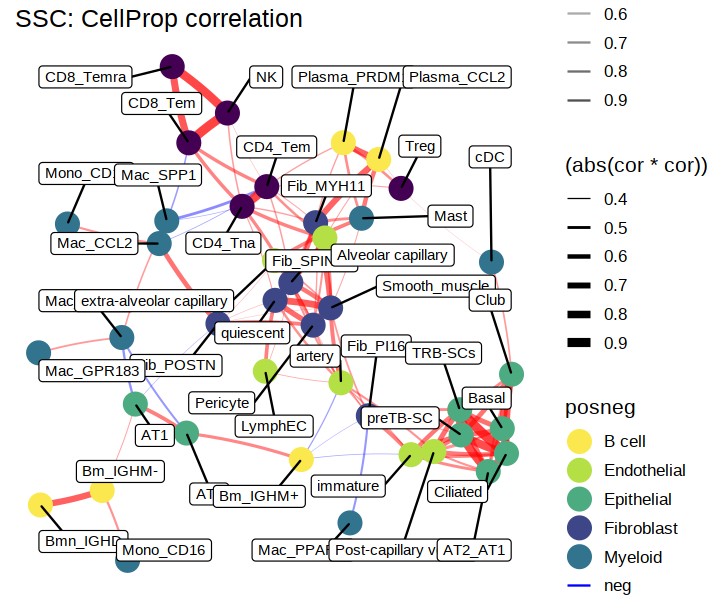

In [17]:
# --- 03-plot SSC CellProp cor network
cor.df <- ssc.cor.pr$r
p.df <- ssc.cor.pr$p
n <- network(cor.df, directed = FALSE)
n %v% "ct_level2" <- colnames(p.df)
rename <- colnames(cor.df)
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Epithelial') %>% .$ct_level2 %>% unique())] <- 'Epithelial'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Endothelial') %>% .$ct_level2 %>% unique())] <- 'Endothelial'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Fibroblast') %>% .$ct_level2 %>% unique())] <- 'Fibroblast'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Myeloid') %>% .$ct_level2 %>% unique())] <- 'Myeloid'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Lymphocyte_B') %>% .$ct_level2 %>% unique())] <- 'B cell'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Lymphocyte_T/NK') %>% .$ct_level2 %>% unique())] <- 'T/NK cell'
n %v% "ct_level1" <- rename
e <- network.edgecount(n)

#cor.gcmec
cor.final <- NULL
for(i in 1: (ncol(cor.df)-1)){
    cor.data <- cor.df[,i][-(1:i)]
    cor.final <- c(cor.final, cor.data)
}

#p.gcmec
p.final <- NULL
for(i in 1: (ncol(p.df)-1)){
    p.data <- p.df[,i][-(1:i)]
    p.final <- c(p.final, p.data)
}
set.edge.attribute(n, "cor", cor.final)
set.edge.attribute(n, "p", p.final)
set.edge.attribute(n, 'posneg', ifelse(cor.final >0, 'pos', 'neg'))

all <- NULL
for(i in 1:e){
    if(n$ mel[[i]]$ atl$ p < 0.05){
        all <- c(all,i)
    }
}
n$ mel <- n$ mel[all]

set.seed(28)
# pdf('./figures/SSC_CellProp_corr.pdf',width = 7.5, height  = 6)
ggplot(n, aes(x = x, y = y, xend = xend, yend = yend)) +
  geom_edges(aes(linewidth = (abs(cor*cor)),color = posneg, alpha = abs(cor)), curvature = 0.05) +
  geom_nodes(aes(colour = ct_level1),size = 6) +
  geom_nodelabel_repel(aes(label =  ct_level2), size = 3, max.overlaps = 100, box.padding = unit(1, "lines"),colour = 'black') +
  scale_color_manual(values = c("pos"= "red", 'neg' = "blue",
                               'Epithelial' = "#4DAB81",
                                'Endothelial' = "#B4E046",
                                'Fibroblast' =  "#3D4787",
                                'Myeloid' =  "#32738E",
                                'B cell' = "#FBE84E",
                                'T/NK cell' = '#440154FF')) +
  # scale_size(range = c(12*min(abs(log2(wilcox_gc$com))), 12*max(abs(log2(wilcox_gc$com)))))+
  scale_linewidth(range = c(0.05,2))+
  scale_alpha(range = c(0.30046,0.75304))+
  theme_blank() +
  ggtitle('SSC: CellProp correlation')
# dev.off()

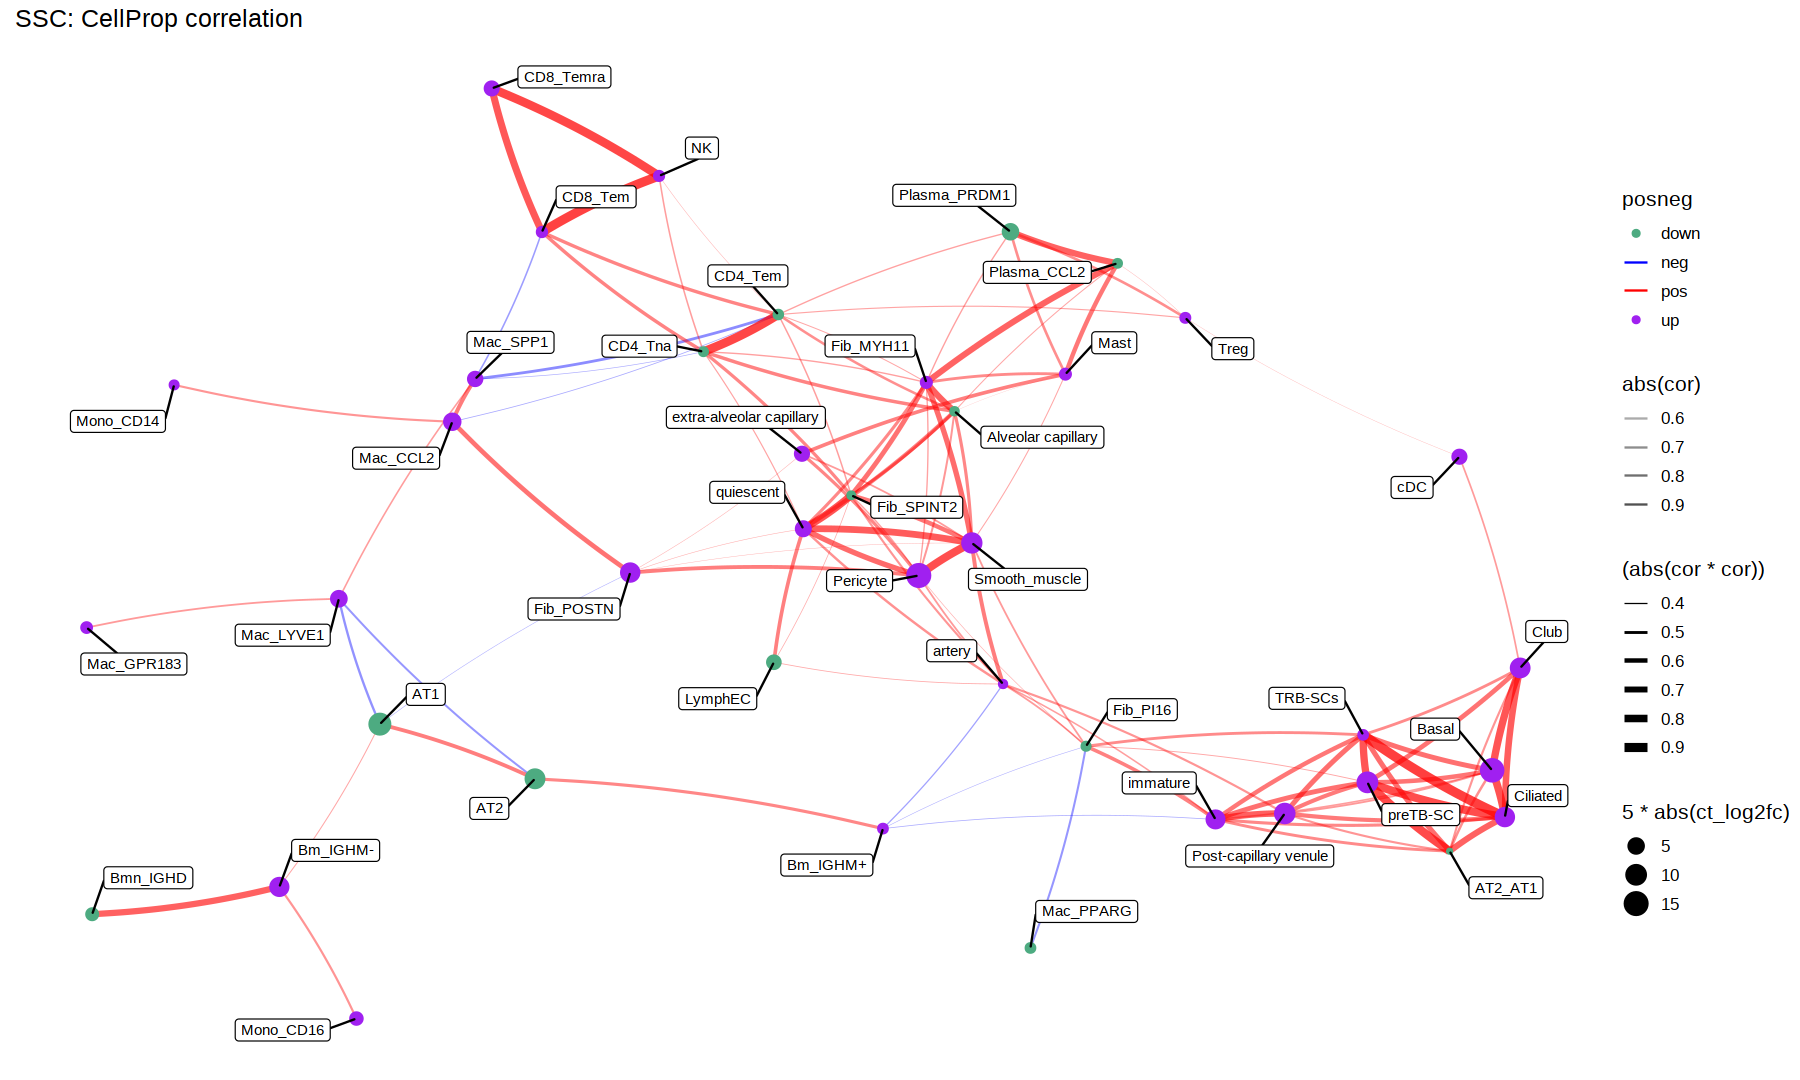

In [18]:
# --- 04-plot CellProp Changes (log2(SSC/HC)) based on SSC network
ratio.log2fc <- left_join(
                        hc.ratio %>% t() %>% as.data.frame() %>% rownames_to_column(var = 'CellSubtype') %>% 
                        pivot_longer(!CellSubtype, names_to = 'HC', values_to = 'ratio') %>% 
                        group_by(CellSubtype) %>% summarise(HC_ratio = mean(ratio)),
                        ssc.ratio %>% t() %>% as.data.frame() %>% rownames_to_column(var = 'CellSubtype') %>% 
                        pivot_longer(!CellSubtype, names_to = 'SSC', values_to = 'ratio') %>% 
                        group_by(CellSubtype) %>% summarise(SSC_ratio = mean(ratio)),
                        by = 'CellSubtype'
                        ) %>%
                    mutate(ratio_log2FC = log2(SSC_ratio/HC_ratio),
                           ratio_class = ifelse(ratio_log2FC > 0, 'up', 'down'))

cor.df <- ssc.cor.pr$r
p.df <- ssc.cor.pr$p
n <- network(cor.df, directed = FALSE)
rename <- colnames(cor.df)
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Epithelial') %>% .$ct_level2 %>% unique())] <- 'Epithelial'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Endothelial') %>% .$ct_level2 %>% unique())] <- 'Endothelial'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Fibroblast') %>% .$ct_level2 %>% unique())] <- 'Fibroblast'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Myeloid') %>% .$ct_level2 %>% unique())] <- 'Myeloid'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Lymphocyte_B') %>% .$ct_level2 %>% unique())] <- 'B cell'
rename[rename %in% (ct.meta %>% dplyr::filter(ct_level1 == 'Lymphocyte_T/NK') %>% .$ct_level2 %>% unique())] <- 'T/NK cell'
n %v% "ct_level2" <- colnames(p.df)
n %v% "ct_level1" <- rename
n %v% "ct_log2fc" <- ratio.log2fc %>% column_to_rownames(var = 'CellSubtype') %>% .[colnames(p.df), 'ratio_log2FC']
n %v% "ct_class" <- ratio.log2fc %>% column_to_rownames(var = 'CellSubtype') %>% .[colnames(p.df), 'ratio_class']
e <- network.edgecount(n)

#cor.gcmec
cor.final <- NULL
for(i in 1: (ncol(cor.df)-1)){
    cor.data <- cor.df[,i][-(1:i)]
    cor.final <- c(cor.final, cor.data)
}

#p.gcmec
p.final <- NULL
for(i in 1: (ncol(p.df)-1)){
    p.data <- p.df[,i][-(1:i)]
    p.final <- c(p.final, p.data)
}
set.edge.attribute(n, "cor", cor.final)
set.edge.attribute(n, "p", p.final)
set.edge.attribute(n, 'posneg', ifelse(cor.final >0, 'pos', 'neg'))

all <- NULL
for(i in 1:e){
    if(n$ mel[[i]]$ atl$ p < 0.05){
        all <- c(all,i)
    }
}
n$ mel <- n$ mel[all]

options(repr.plot.height = 9, repr.plot.width = 15)  
set.seed(28)
# pdf('./figures/SSCvsHC_CellProp_corr.pdf',width = 7.5, height  = 6)
ggplot(n, aes(x = x, y = y, xend = xend, yend = yend)) +
  geom_edges(aes(linewidth = (abs(cor*cor)),color = posneg, alpha = abs(cor)), curvature = 0.05) +
  geom_nodes(aes(colour = ct_class, size = 5*abs(ct_log2fc))) +
  geom_nodelabel_repel(aes(label = ct_level2), size = 3, max.overlaps = 100, box.padding = unit(1, "lines"),colour = 'black') +
  scale_color_manual(values = c("pos"= "red", 'neg' = "blue",
                               'down' = "#4DAB81",
                                'up' = "purple")) +
  # scale_size(range = c(12*min(abs(log2(wilcox_gc$com))), 12*max(abs(log2(wilcox_gc$com)))))+
  scale_linewidth(range = c(0.05,2))+
  scale_alpha(range = c(0.30046,0.75304))+
  theme_blank() +
  ggtitle('SSC: CellProp correlation')
# dev.off()

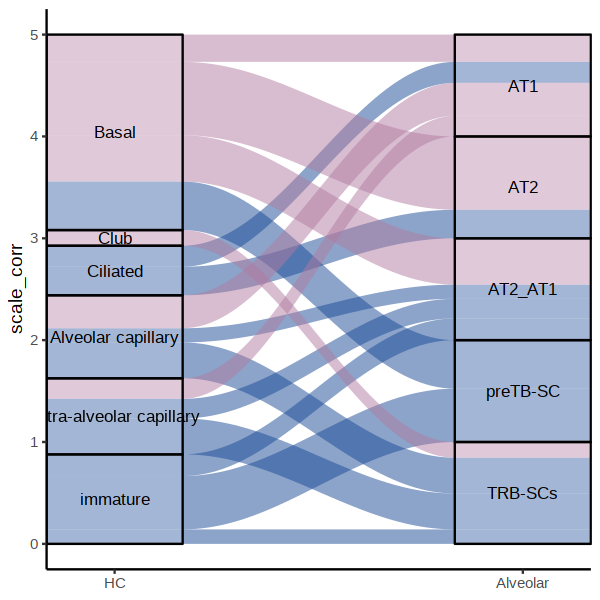

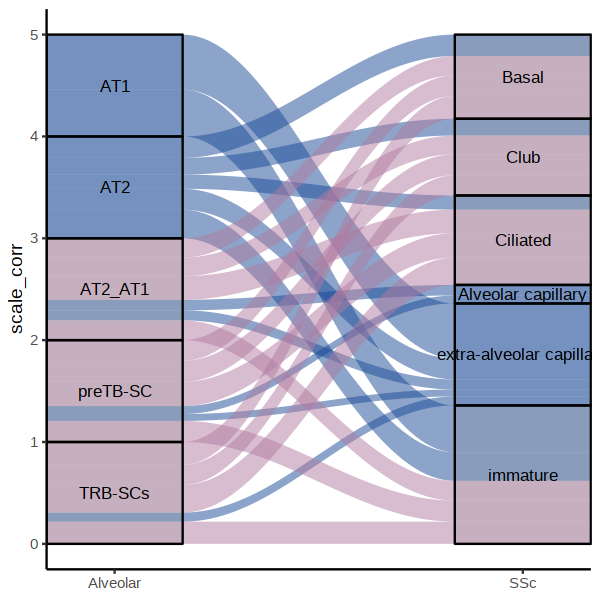

In [19]:
# --- CellProp Correlation in Epithelial and Enodothelial
library(ggalluvial)
ct1.level <- c('Basal', 'Club', 'Ciliated', 'Alveolar capillary', 'extra-alveolar capillary', 'immature')
options(repr.plot.height = 5, repr.plot.width = 5)

cell.cor <- hc.cor.pr$r %>% as.data.frame() %>% rownames_to_column(var = 'Alveolar') %>% 
            pivot_longer(!Alveolar, names_to = 'HC', values_to = 'CellProp_Corr') %>%
            dplyr::filter(Alveolar %in% c('AT1', 'AT2', 'AT2_AT1', 'TRB-SCs', 'preTB-SC')) %>%
            dplyr::filter(HC %in% c('Basal', 'Club', 'Ciliated', 'Alveolar capillary', 'extra-alveolar capillary', 'immature')) %>%
            dplyr::filter(abs(CellProp_Corr) >= 0.2)

cell.cor.sum <- cell.cor %>% mutate(corr = abs(CellProp_Corr)) %>% group_by(Alveolar) %>% summarise(sum_corr = sum(corr))
cell.cor.df <- cell.cor %>%
                left_join(cell.cor.sum, by = 'Alveolar') %>% 
                mutate(scale_corr = abs(CellProp_Corr)/sum_corr,
                       Change = ifelse(CellProp_Corr > 0, 'UP', 'DOWN'))  
cell.cor.df$HC <- factor(cell.cor.df$HC, levels = ct1.level)
cell.cor.df %>%
ggplot(aes(y = scale_corr, axis1 = HC, axis2 = Alveolar))+
  geom_alluvium(aes(fill = Change), curve_type = "sine") +
  scale_fill_manual(values = c('UP' = "#B17AA1", 'DOWN' = "#184995")) +
  guides(fill = "none") +
  geom_stratum(alpha = .2) +
  geom_text(stat = "stratum", size=3.5, aes(label = after_stat(stratum)),reverse = T) +
  scale_x_continuous(breaks = 1:2, expand = c(0,0), labels = c("HC", "Alveolar")) +
  theme_classic() 
# ggsave('./figures/Sankey_CellProp_HC.pdf', width = 4, heigh = 5)

cell.cor <- ssc.cor.pr$r %>% as.data.frame() %>% rownames_to_column(var = 'Alveolar') %>% 
            pivot_longer(!Alveolar, names_to = 'SSc', values_to = 'CellProp_Corr') %>%
            dplyr::filter(Alveolar %in% c('AT1', 'AT2', 'AT2_AT1', 'TRB-SCs', 'preTB-SC')) %>%
            dplyr::filter(SSc %in% c('Basal', 'Club', 'Ciliated', 'Alveolar capillary', 'extra-alveolar capillary', 'immature'))%>%
            dplyr::filter(abs(CellProp_Corr) >= 0.2)

cell.cor.sum <- cell.cor %>% mutate(corr = abs(CellProp_Corr)) %>% group_by(Alveolar) %>% summarise(sum_corr = sum(corr))
cell.cor.df <- cell.cor %>%
                left_join(cell.cor.sum, by = 'Alveolar') %>% 
                mutate(scale_corr = abs(CellProp_Corr)/sum_corr,
                      Change = ifelse(CellProp_Corr > 0, 'UP', 'DOWN'))  
cell.cor.df$SSc <- factor(cell.cor.df$SSc, levels = ct1.level)
cell.cor.df %>%
ggplot(aes(y = scale_corr, axis1 = Alveolar, axis2 = SSc, fill = Change))+
  # geom_flow()+
  geom_alluvium(aes(fill = Change), curve_type = "sine") +
  scale_fill_manual(values = c('UP' = "#B17AA1", 'DOWN' = "#184995")) +
  guides(fill = "none") +
  geom_stratum(alpha = .2) +
  geom_text(stat = "stratum", size=3.5, aes(label = after_stat(stratum)),reverse = T) +
  scale_x_continuous(breaks = 1:2, expand = c(0,0), labels = c("Alveolar", 'SSc')) +
  theme_classic() 
# ggsave('./figures/Sankey_CellProp_SSc.pdf', width = 4, heigh = 5)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”
Warning message in left_join(., distinct(immune.cluster@meta.data[, c("Sample_CT", :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 6 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”
`summarise()` has grouped output by 'gene', 'Group', 'ct_level1'. You can
override using the `.groups` argument.


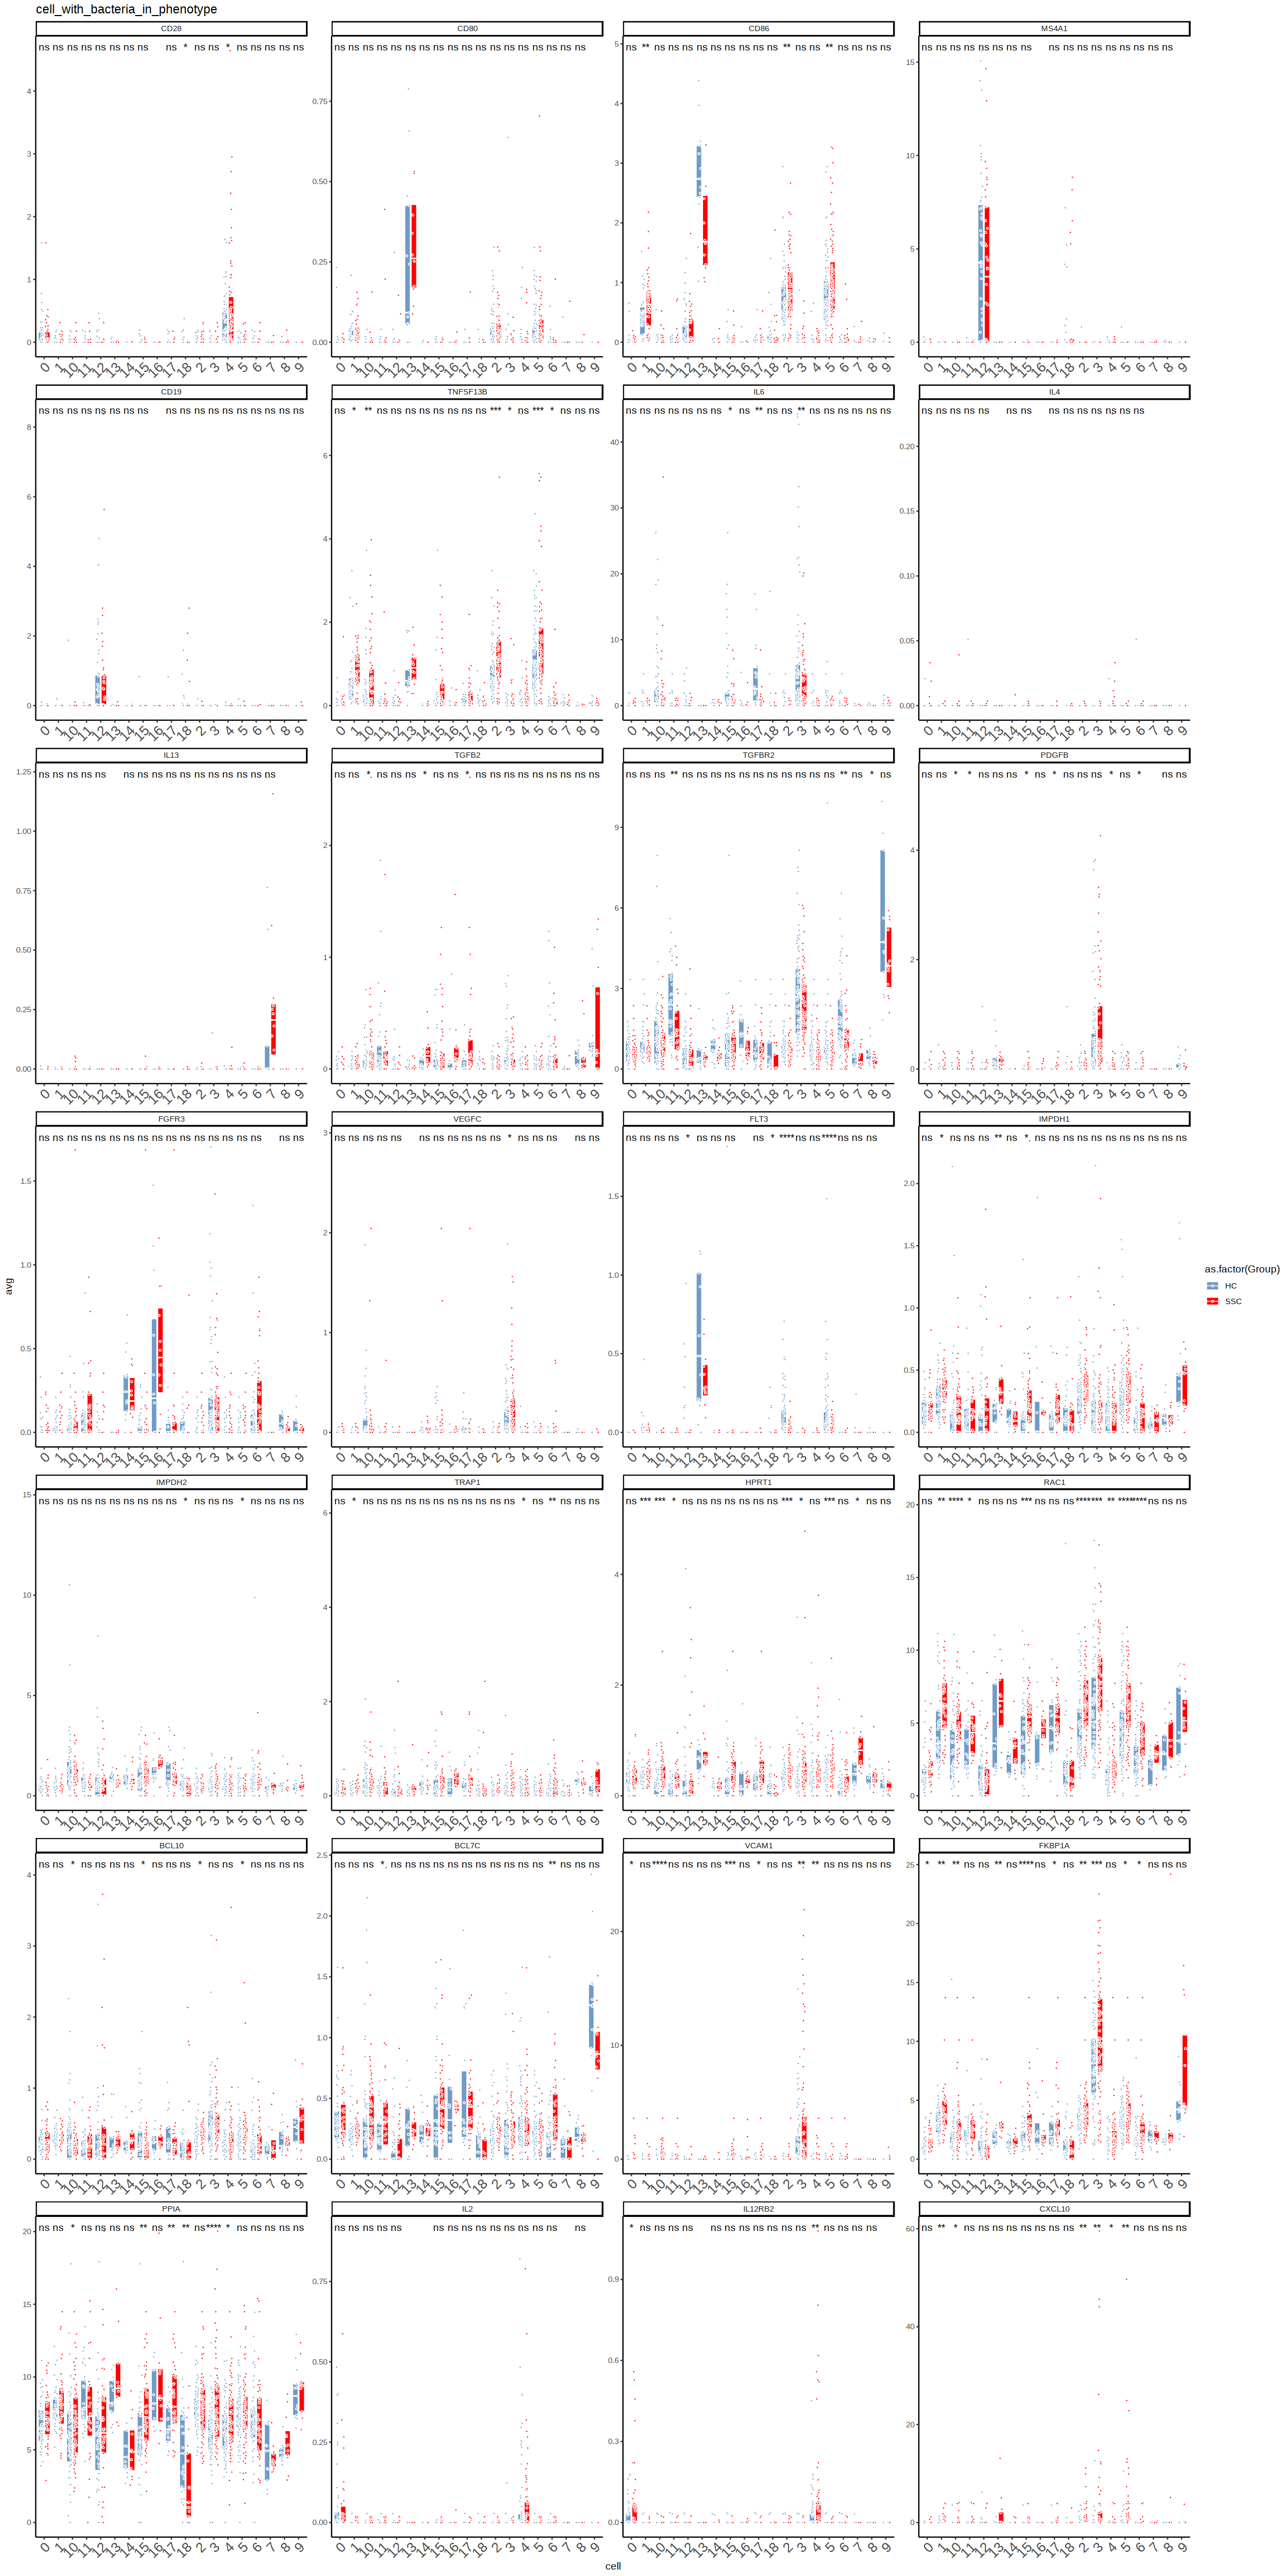

In [21]:
# --- 01-Drug target Genes: 
immune.f <- immune.cluster %>% subset(ct_level2 != '')
tar.genes <- c(
    # 免疫抑制剂：
    'PPIA', 'IL12RB2','CXCL10', # Tacrolimus_Cyclophosphamide: direct 'FKBP', Tcell('NFAT','IL2') DC(CXCL10, IL12)
    'HPRT1', 'RAC1', 'BCL7B', 'BCLAF3', # Azathioprine: 
    # NFAT(T cell activateion); RAC1(Tcell apoptosis), BCL-XL(B cell), VCAM1/ICAM1(Endothelial) 
    'IMPDH1', 'IMPDH2', 'CD40LG', # MMF: mycophenolate mofetil 'CD40L'（这个基因没有，用的别称：TRAP1）
    
    # 生物制剂
    'CD28', 'CD86', # Abatacept
    'PDGFRB', 'VEGFD',# Nintedanib [https://go.drugbank.com/drugs/DB09079]
               # [https://www.nature.com/articles/s41584-020-0374-8?fromPaywallRec=false]:
    # 单抗: 有 receptor-ligand的两个各挑一个，没有的就保留一个就行
   'MS4A1', #'CD20', Rituximab
   'CD19', # Inebilizumab
   'TNFSF13B', 'TNFRSF9', # Belimumab
   'IL6', 'IL6R', # Tocilizumab
   'IL4', 'IL10RB', # Romilkimab
   'TGFB2','TGFBR1' # Fresolimumab
              ) 

# --- 02-Choose target genes
meta <- immune.cluster@meta.data
meta$cell <- as.character(meta$cell)
meta$cell[which(meta$cell %in% c('AT', 'cc', 'lbc'))] <- 'Epithelial'
meta$cell[which(meta$cell == 't_nk')] <- 'T/NK_cell'
meta$cell[which(meta$cell == 'mono')] <- 'Monocyte/Macrophage'
meta$cell[which(meta$cell == 'ec')] <- 'Endothelial'
meta$cell[which(meta$cell == 'mast')] <- 'Mast'
meta$cell[which(meta$cell == 'cec')] <- 'cEC'
meta$cell[which(meta$cell == 'lec')] <- 'lymEC'
meta$cell[which(meta$cell == 'fib')] <- 'Fibroblast'
meta$cell[which(meta$cell == 'cDC')] <- 'cDC'
immune.cluster@meta.data <- meta %>% mutate(Sample_CT = paste0(SampleID, '|', ct_level2))
tar.genes <- c('CD28', 'CD80', 'CD86', # Abatacept
               'MS4A1', #'CD20', Rituximab
               'CD19', # Inebilizumab
               'TNFSF13B', # Belimumab
               'IL6', # Tocilizumab
               'IL4', 'IL13', # Romilkimab
               'TGFB2', 'TGFBR2', # Fresolimumab
               # prednisolone
                 'PDGFB', 'FGFR3', 'VEGFC', 'FLT3',# Nintedanib [https://go.drugbank.com/drugs/DB09079] 
               # [https://www.nature.com/articles/s41584-020-0374-8?fromPaywallRec=false]:
               'IMPDH1', 'IMPDH2', 'TRAP1', # MMF: mycophenolate mofetil 'CD40L'
               'HPRT1', 'RAC1', 'BCL10', 'BCL7C', 'VCAM1', # Azathioprine: NFAT(T cell activateion); RAC1(Tcell apoptosis), BCL-XL(B cell), VCAM1/ICAM1(Endothelial)
               'FKBP1A','PPIA', 'IL2','IL12RB2','CXCL10' # Tacrolimus/cyclophosphamide: direct 'FKBP', Tcell('NFAT','IL2') DC(CXCL10, IL12)
              ) 

DefaultAssay(immune.cluster) <- 'RNA'
sam.avg <- AverageExpression(immune.cluster, assays = 'RNA', group.by = 'Sample_CT')
avg.df <- sam.avg$RNA[tar.genes,] %>% as.data.frame() %>%
            rownames_to_column(var = 'gene') %>% pivot_longer(!gene, names_to = 'Sample_CT', values_to = 'avg') %>% as.data.frame() %>%
            left_join(distinct(immune.cluster@meta.data[,c('Sample_CT', 'SampleID', 'Group', 'cell')] %>% {rownames(.) <- NULL; .}), by = 'Sample_CT')


options(repr.plot.height = 40, repr.plot.width = 20)
avg.df$gene <- factor(avg.df$gene, levels = tar.genes)
avg.df %>% #dplyr::filter(gene %in% c('IL6', 'IL13', 'IL17A', 'TGFA', 'TGFB1', 'TGFBI', 'TGFB1I1', 'TGFB2'))%>%
ggplot(aes(y = avg, x = cell, fill = as.factor(Group))) + #
  geom_boxplot(outlier.shape = NA, position=position_dodge(width=0.9), size = 0.3, colour = "white") +
  geom_point(pch = 21, position = position_jitterdodge(), colour = "white", size = 0.5) +
  #   geom_jitter( size = 0.6 , position=position_dodge(width=0.9),aes(group=SampleType, alpha = 0.6)) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=15)) +
  ggtitle("cell_with_bacteria_in_phenotype") +
  scale_fill_manual(values = c('#6F9BC6','red','#F9B800')) +
  stat_compare_means(label =  "p.signif", label.x = 10, method = "t.test") +
  facet_wrap(~gene, scales = 'free', ncol = 4)
ggsave('DrugTarGenes.pdf', width = 20, height = 35)


# --- 03—calculate CellSubtype Genes expression
immune.f@meta.data <- immune.f@meta.data %>% mutate(Sample_CT = paste0(SampleID, '|', ct_level2))
DefaultAssay(immune.f) <- 'RNA'
sam.avg <- AverageExpression(immune.f, assays = 'RNA', group.by = 'ct_level2')
ct.avg <- sam.avg$RNA[tar.genes,] %>% as.data.frame() %>% rownames_to_column(var = 'gene') %>% 
                pivot_longer(!gene, names_to = 'ct_level2', values_to = 'ct_express') 
ct.avg$Drug <- ''
ct.avg$Drug[which(ct.avg$gene %in% c('CD28', 'CD86'))] <- 'Abatacept'
ct.avg$Drug[which(ct.avg$gene == 'MS4A1')] <- 'Rituximab'
ct.avg$Drug[which(ct.avg$gene == 'CD19')] <- 'Inebilizumab'
ct.avg$Drug[which(ct.avg$gene %in% c('TNFSF13B', 'TNFRSF9'))] <- 'Belimumab'
ct.avg$Drug[which(ct.avg$gene %in% c('IL6', 'IL6R'))] <- 'Tocilizumab' 
ct.avg$Drug[which(ct.avg$gene %in% c('IL4', 'IL10RB'))] <- 'Romilkimab'
ct.avg$Drug[which(ct.avg$gene %in% c('TGFB2','TGFBR1'))] <- 'Fresolimumab'
ct.avg$Drug[which(ct.avg$gene %in% c('PDGFRB', 'VEGFD'))] <- 'Nintedanib'
ct.avg$Drug[which(ct.avg$gene %in% c('IMPDH1', 'IMPDH2', 'CD40LG'))] <- 'MMF'
ct.avg$Drug[which(ct.avg$gene %in% c('HPRT1', 'RAC1', 'BCL10', 'BCL7C', 'VCAM1', 'BCL7B', 'BCLAF3'))] <- 'Azathioprine'
ct.avg$Drug[which(ct.avg$gene %in% c('FKBP1A','PPIA', 'IL2','IL12RB2','CXCL10'))] <- 'Tacrolimus_Cyclophosphamide'

# --- calculate Sample_CellSubtype Genes expression
DefaultAssay(immune.f) <- 'RNA'
sam.avg <- AverageExpression(immune.f, assays = 'RNA', group.by = 'Sample_CT')
sample.ct.avg <- sam.avg$RNA[tar.genes,] %>% as.data.frame()  %>% rownames_to_column(var = 'gene') %>% 
                    pivot_longer(!gene, names_to = 'Sample_CT', values_to = 'sample_ct_express') %>% 
                    left_join(distinct(immune.f@meta.data[,c('Sample_CT', 'SampleID', 'Group','ct_level1', 'ct_level2')] %>% {rownames(.) <- NULL; .}), by = 'Sample_CT') %>%
                    group_by(gene, Group, ct_level1, ct_level2) %>% summarise(mean_express = mean(sample_ct_express)) %>%
                    pivot_wider(names_from = 'Group', values_from = 'mean_express') %>%
                    mutate(gene_log2fc = log2(SSC/HC)) %>%
                    left_join(distinct(ct.avg[,c('gene','Drug')]), by = 'gene')
sample.ct.avg$gene_log2fc[which(sample.ct.avg$gene_log2fc == 'Inf')] <- '10'
sample.ct.avg$gene_log2fc[which(sample.ct.avg$gene_log2fc == '-Inf')] <- '-10'
sample.ct.avg$gene_log2fc <- as.numeric(sample.ct.avg$gene_log2fc)
sample.ct.avg <- sample.ct.avg %>% na.omit()
sample.ct.avg$alpha_value <- 0.1
sample.ct.avg$alpha_value[which(abs(sample.ct.avg$gene_log2fc) >= 0.25 & abs(sample.ct.avg$gene_log2fc) < 0.5)] <- 0.2
sample.ct.avg$alpha_value[which(abs(sample.ct.avg$gene_log2fc) >= 0.5 & abs(sample.ct.avg$gene_log2fc) < 0.75)] <- 0.4
sample.ct.avg$alpha_value[which(abs(sample.ct.avg$gene_log2fc) >= 0.75 & abs(sample.ct.avg$gene_log2fc) < 1)] <- 0.6
sample.ct.avg$alpha_value[which(abs(sample.ct.avg$gene_log2fc) >= 1 & abs(sample.ct.avg$gene_log2fc) < 3)] <- 0.8
sample.ct.avg$alpha_value[which(abs(sample.ct.avg$gene_log2fc) >= 3)] <- 1

# --- 04-Plot
gene.list <- tar.genes
for(TarGen in gene.list){
    # TarGen = 'BCL10'
    ct.exp.log2fc <- left_join(
                            ct.avg %>% dplyr::filter(gene == TarGen) %>% mutate(Gene_CT = paste0(gene, '|', ct_level2)),
                            sample.ct.avg %>% dplyr::filter(gene == TarGen) %>% mutate(Gene_CT = paste0(gene, '|', ct_level2)) %>% .[,c('Gene_CT', 'ct_level1', 'gene_log2fc', 'alpha_value')],
                            by = 'Gene_CT'
                            )
    ct.exp.log2fc$gene_log2fc <- as.numeric(ct.exp.log2fc$gene_log2fc)
    ct.exp.log2fc <- ct.exp.log2fc %>% mutate(log2fc_class = ifelse(gene_log2fc > 0, 'UP', 'DOWN'))    
    df <- ct.exp.log2fc %>% arrange(-ct_express) %>% .[1:5,] %>% mutate(ct_label = ct_level2)
    df$ct_level2 <- factor(df$ct_level2, levels = rev(df$ct_level2))

    options(repr.plot.height = 3, repr.plot.width = 5)    
    pdf(paste0('./figures/Drug/', unique(df$Drug), '_', TarGen, '.pdf'), width = 5, height = 3)
    p <- df %>% ggplot(aes(y = ct_level2)) +
          geom_bar(aes(x = ct_express, fill = ct_level1), width = 0.75, stat = "identity",  alpha = 0.7) +  # Barplot
          scale_fill_manual(values = c('Epithelial' = "#4DAB81",
                                      'Endothelial' = "#B4E046",
                                      'Fibroblast' =  "#3D4787",
                                      'Myeloid' =  "#32738E",
                                      'Lymphocyte_B' = "#FBE84E",
                                      'Lymphocyte_T/NK' = '#440154FF')) +
          geom_text(aes(label = ct_label), x = 2*max(df$ct_express)/5, vjust = 0.75, size = 5, color = "black") + # Labels on top of bars     
          geom_point(aes(color = log2fc_class), x = -max(df$ct_express)/5, size = 7, alpha = df$alpha_value) +   # Single dot
          scale_color_manual(values = c("UP"= "#B17AA1", 'DOWN' = "#184995")) +    
          # scale_alpha_continuous(range = c(0.1, 1)) +
          scale_x_continuous(limits = c(-max(df$ct_express)/5, max(df$ct_express))) +    
          theme_minimal() +
          theme(axis.text.y = element_blank()) +
          labs(y = "", x = TarGen) +
          ggtitle(unique(df$Drug))
    print(p)
    dev.off()
}

In [22]:
# --- 1)Average Gene Expression
DefaultAssay(immune.cluster) <- 'RNA'
sam.avg <- AverageExpression(immune.cluster, assays = 'RNA', group.by = 'Sample_CT')
avg.df <- sam.avg$RNA[tar.genes,] %>% as.data.frame() %>%
            rownames_to_column(var = 'gene') %>% pivot_longer(!gene, names_to = 'Sample_CT', values_to = 'avg') %>% as.data.frame() %>%
            left_join(distinct(immune.cluster@meta.data %>% {rownames(.) <- NULL; .} %>% .[,c('Sample_CT', 'SampleID', 'Group', 'cell')]), by = 'Sample_CT')

ct.all <- NULL
gene.all <- NULL
log.mean.all <- NULL
log.sum.all <- NULL
t.stat.all <- NULL
t.pval.all <- NULL
wilcox.stat.all <- NULL
wilcox.pval.all <- NULL

for(celltype in unique(avg.df$cell)){
# celltype = 'b'
    for(targene in unique(avg.df$gene)){
        log.df <- avg.df %>% dplyr::filter(cell == celltype & gene == targene) %>% 
                    group_by(Group) %>% summarise(mean = mean(avg), sum = sum(avg)) %>% 
                    column_to_rownames(var = 'Group') %>% t() %>% as.data.frame() %>%
                    mutate(log2FC = SSC/HC) 
        hc.avg <- avg.df %>% dplyr::filter(cell == celltype  & gene == targene & Group == 'HC') %>% pull(avg)
        ssc.avg <- avg.df %>% dplyr::filter(cell == celltype  & gene == targene & Group == 'SSC') %>% pull(avg)
        t.df <- t.test(hc.avg, ssc.avg)
        wilcox.df <- wilcox.test(hc.avg, ssc.avg)

        ct.all <- ct.all %>% append(celltype)
        gene.all <- gene.all %>% append(targene)
        log.mean.all <- log.mean.all %>% append(log.df$log2FC[1])
        log.sum.all <- log.sum.all %>% append(log.df$log2FC[2])
        t.stat.all <- t.stat.all %>% append(t.df$statistic)
        t.pval.all <- t.pval.all %>% append(t.df$p.value)
        wilcox.stat.all <- wilcox.stat.all %>% append(wilcox.df$statistic)
        wilcox.pval.all <- wilcox.pval.all %>% append(wilcox.df$p.value)
        }
}
drug.df <- data.frame(CellType = ct.all,
                     gene = gene.all,
                     mean_log2FC = log.mean.all,
                     sum_log2FC = log.sum.all,
                     t_stat = t.stat.all,
                     t_pval = t.pval.all,
                     wilcox_stat= wilcox.stat.all,
                     wilcox_pval = wilcox.pval.all
                    )
head(drug.df)
# write.csv(drug.df, 'DrugGenes_avg_log2FC.csv')

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”
Warning message in left_join(., distinct(immune.cluster@meta.data %>% {:
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 6 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”
Warning message in wilcox.test.default(hc.avg, ssc.avg):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(hc.avg, ssc.avg):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(hc.avg, ssc.avg):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(hc.avg, ssc.avg):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(hc.avg, ssc.avg):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(hc.avg, ssc.avg):
“cannot comp

CellType gene     mean_log2FC sum_log2FC t_stat     t_pval     wilcox_stat
1 3        CD28     1.6701341   1.6308368  -0.7685555 0.44346814 3423.0     
2 3        CD80     0.2481264   0.2422881   1.0182419 0.31136831 3558.0     
3 3        CD86     1.5695202   1.5325903  -0.8553241 0.39361306 3294.0     
4 3        MS4A1    0.8475388   0.8275967   0.2453054 0.80652618 3723.0     
5 3        CD19     1.8537918   1.8101732  -0.7917992 0.43028628 3633.0     
6 3        TNFSF13B 2.6525140   2.5901019  -2.0750825 0.04075957 3207.5     
  wilcox_pval
1 0.5876695  
2 0.8881255  
3 0.3467009  
4 0.2815861  
5 0.5446556  
6 0.2644010

In [193]:
drug.df <- read.csv('DrugGenes_log2FC.csv')
drug.df <- drug.df %>% mutate(mean_log2FC = log2(mean_log2FC), sum_log2FC = log2(sum_log2FC))
drug.df[is.na(drug.df)] <- 0

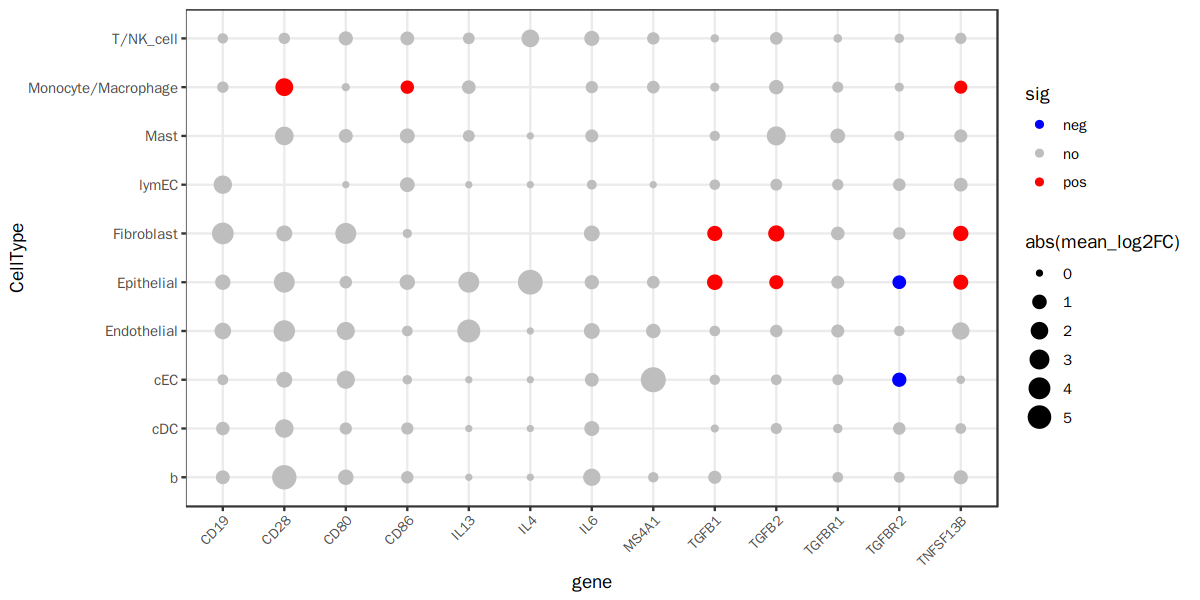

In [195]:
drug.mean.t <- drug.df[,c('CellType', 'gene', 'mean_log2FC', 't_pval')]
drug.mean.t$sig <- 'no'
drug.mean.t$sig[which(drug.mean.t$t_pval < 0.05 & drug.mean.t$mean_log2FC > 0)] <- 'pos'
drug.mean.t$sig[which(drug.mean.t$t_pval < 0.05 & drug.mean.t$mean_log2FC < 0)] <- 'neg'

ggplot(drug.mean.t, aes(x = gene, y = CellType)) + 
    geom_point(aes(size = abs(mean_log2FC), color= sig)) + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size=8)) +
    scale_color_manual(values = c("pos"= "red", 'no' = 'grey', 'neg' = "blue")) 

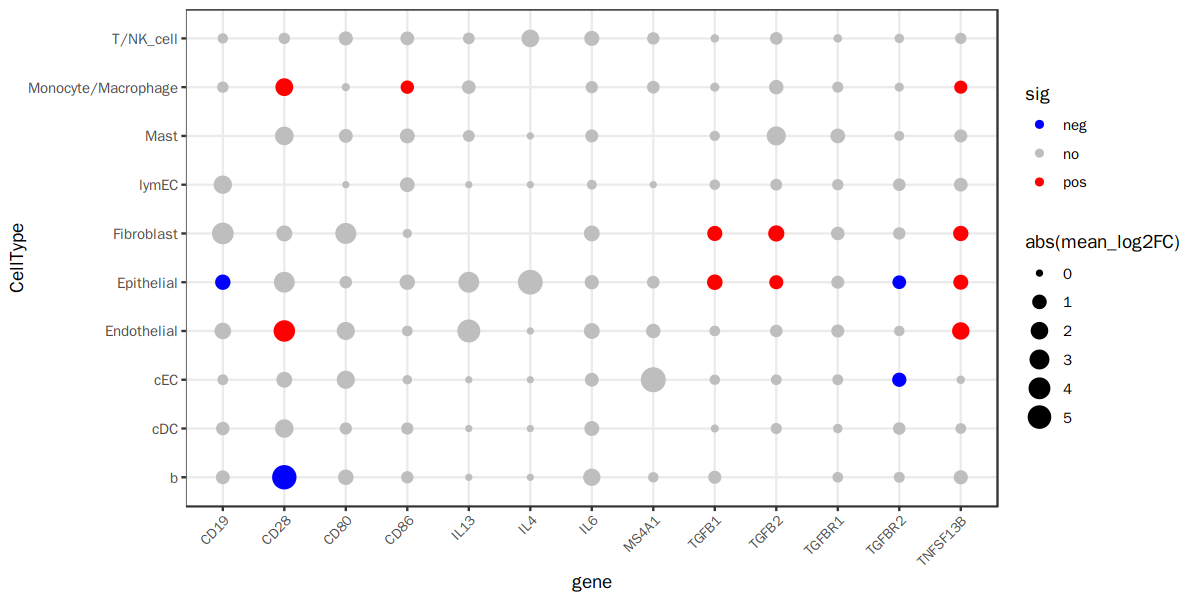

In [197]:
drug.mean.wilcox <- drug.df[,c('CellType', 'gene', 'mean_log2FC', 'wilcox_pval')]
drug.mean.wilcox$sig <- 'no'
drug.mean.wilcox$sig[which(drug.mean.wilcox$wilcox_pval < 0.05 & drug.mean.wilcox$mean_log2FC > 0)] <- 'pos'
drug.mean.wilcox$sig[which(drug.mean.wilcox$wilcox_pval < 0.05 & drug.mean.wilcox$mean_log2FC < 0)] <- 'neg'

ggplot(drug.mean.wilcox, aes(x = gene, y = CellType)) + 
    geom_point(aes(size = abs(mean_log2FC), color= sig)) + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size=8)) +
    scale_color_manual(values = c("pos"= "red", 'no' = 'grey', 'neg' = "blue")) 

In [231]:
# # --- 2) Summary Gene Expression
# sum.df <- immune.cluster[['RNA']]@data %>% .[tar.genes,] %>% t() %>% as.data.frame() %>% rownames_to_column(var = 'barcode') %>%
#                 left_join(immune.cluster@meta.data %>% rownames_to_column(var = 'barcode') %>% .[, c('barcode','Sample_CT')], by = 'barcode') %>% 
#                 .[,2:length(colnames(.))] %>% pivot_longer(!Sample_CT, names_to = 'gene', values_to = 'express') %>%
#                     group_by(Sample_CT, gene) %>% summarise(sum = sum(express)) %>% as.data.frame() %>%
#                 left_join(immune.cluster@meta.data[, c('Sample_CT', 'SampleID', 'Group', 'cell')] %>% distinct(), by = 'Sample_CT') 

# ct.all <- NULL
# gene.all <- NULL
# log.sum.all <- NULL
# t.stat.all <- NULL
# t.pval.all <- NULL
# wilcox.stat.all <- NULL
# wilcox.pval.all <- NULL

# for(celltype in unique(sum.df$cell)){
# # celltype = 'b'
#     for(targene in unique(sum.df$gene)){
#         print(targene)
#         log.df <- sum.df %>% dplyr::filter(cell == celltype & gene == targene) %>% 
#                     group_by(Group) %>% summarise(mean = mean(sum), sum = sum(sum)) %>% 
#                     column_to_rownames(var = 'Group') %>% t() %>% as.data.frame() %>%
#                     mutate(log2FC = log2(SSC/HC))
#         hc.sum <- sum.df %>% dplyr::filter(cell == celltype  & gene == targene & Group == 'HC') %>% pull(sum)
#         ssc.sum <- sum.df %>% dplyr::filter(cell == celltype  & gene == targene & Group == 'SSC') %>% pull(sum)
#         t.df <- t.test(hc.sum, ssc.sum)
#         wilcox.df <- wilcox.test(hc.sum, ssc.sum)

#         ct.all <- ct.all %>% append(celltype)
#         gene.all <- gene.all %>% append(targene)
#         log.sum.all <- log.sum.all %>% append(log.df$log2FC[1])
#         t.stat.all <- t.stat.all %>% append(t.df$statistic)
#         t.pval.all <- t.pval.all %>% append(t.df$p.value)
#         wilcox.stat.all <- wilcox.stat.all %>% append(wilcox.df$statistic)
#         wilcox.pval.all <- wilcox.pval.all %>% append(wilcox.df$p.value)
#         }
# }
# drug.df <- data.frame(CellType = ct.all,
#                      gene = gene.all,
#                      sum_log2FC = log.sum.all,
#                      t_stat = t.stat.all,
#                      t_pval = t.pval.all,
#                      wilcox_stat= wilcox.stat.all,
#                      wilcox_pval = wilcox.pval.all
#                     )
# write.csv(drug.df, 'DrugGenes_sum_log2FC.csv')

In [236]:
drug.df <- read.csv('DrugGenes_sum_log2FC.csv')
drug.df[is.na(drug.df)] <- 0

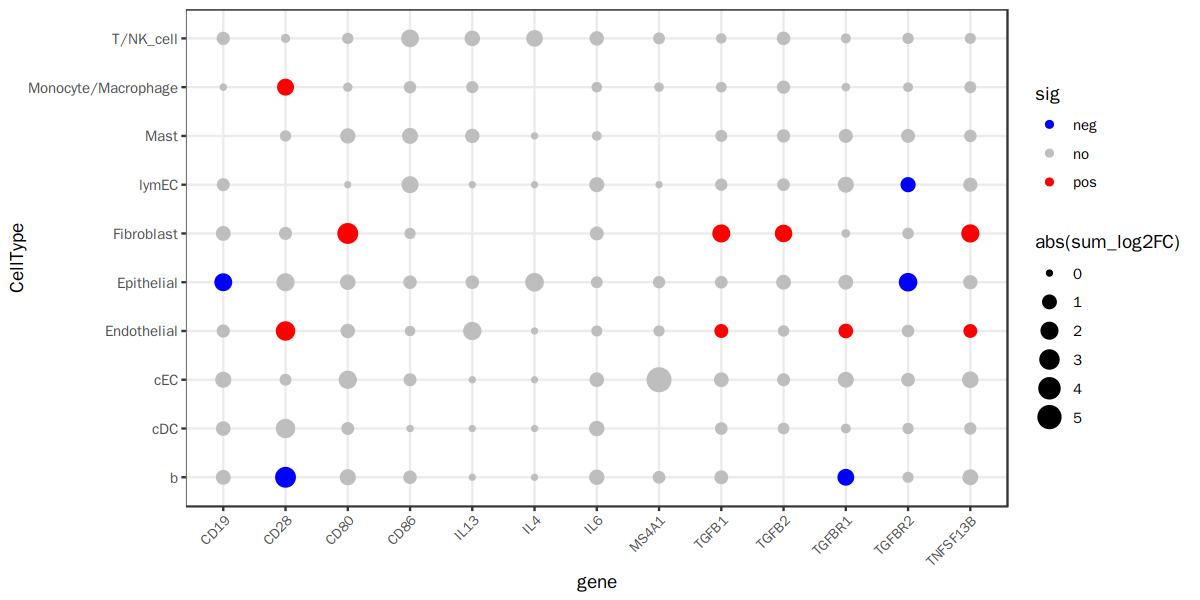

In [239]:
drug.sum.wilcox <- drug.df[,c('CellType', 'gene', 'sum_log2FC', 'wilcox_pval')]
drug.sum.wilcox$sig <- 'no'
drug.sum.wilcox$sig[which(drug.sum.wilcox$wilcox_pval < 0.05 & drug.sum.wilcox$sum_log2FC > 0)] <- 'pos'
drug.sum.wilcox$sig[which(drug.sum.wilcox$wilcox_pval < 0.05 & drug.sum.wilcox$sum_log2FC < 0)] <- 'neg'

ggplot(drug.sum.wilcox, aes(x = gene, y = CellType)) + 
    geom_point(aes(size = abs(sum_log2FC), color= sig)) + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size=8)) +
    scale_color_manual(values = c("pos"= "red", 'no' = 'grey', 'neg' = "blue")) 

`summarise()` has grouped output by 'ct_level2'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'id'. You can override using the `.groups` argument.


id ct_level2                tot  hjust angle
1 1  Alveolar capillary       2086 0     86.25
2 2  extra-alveolar capillary 1676 0     78.75
3 3  artery                   1218 0     71.25
4 4  immature                 1108 0     63.75
5 5  LymphEC                   894 0     56.25
6 6  Post-capillary venule     833 0     48.75

ct_level1       start end title
1 Endothelial      1     7   4.0 
2 Epithelial       9    16  12.5 
3 Fibroblast      18    24  21.0 
4 Lymphocyte_B    26    30  28.0 
5 Lymphocyte_T/NK 32    37  34.5 
6 Myeloid         39    47  43.0

ct_level1       start end title
1 Epithelial       8     8  12.5 
2 Fibroblast      17    17  21.0 
3 Lymphocyte_B    25    25  28.0 
4 Lymphocyte_T/NK 31    31  34.5 
5 Myeloid         38    38  43.0

Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


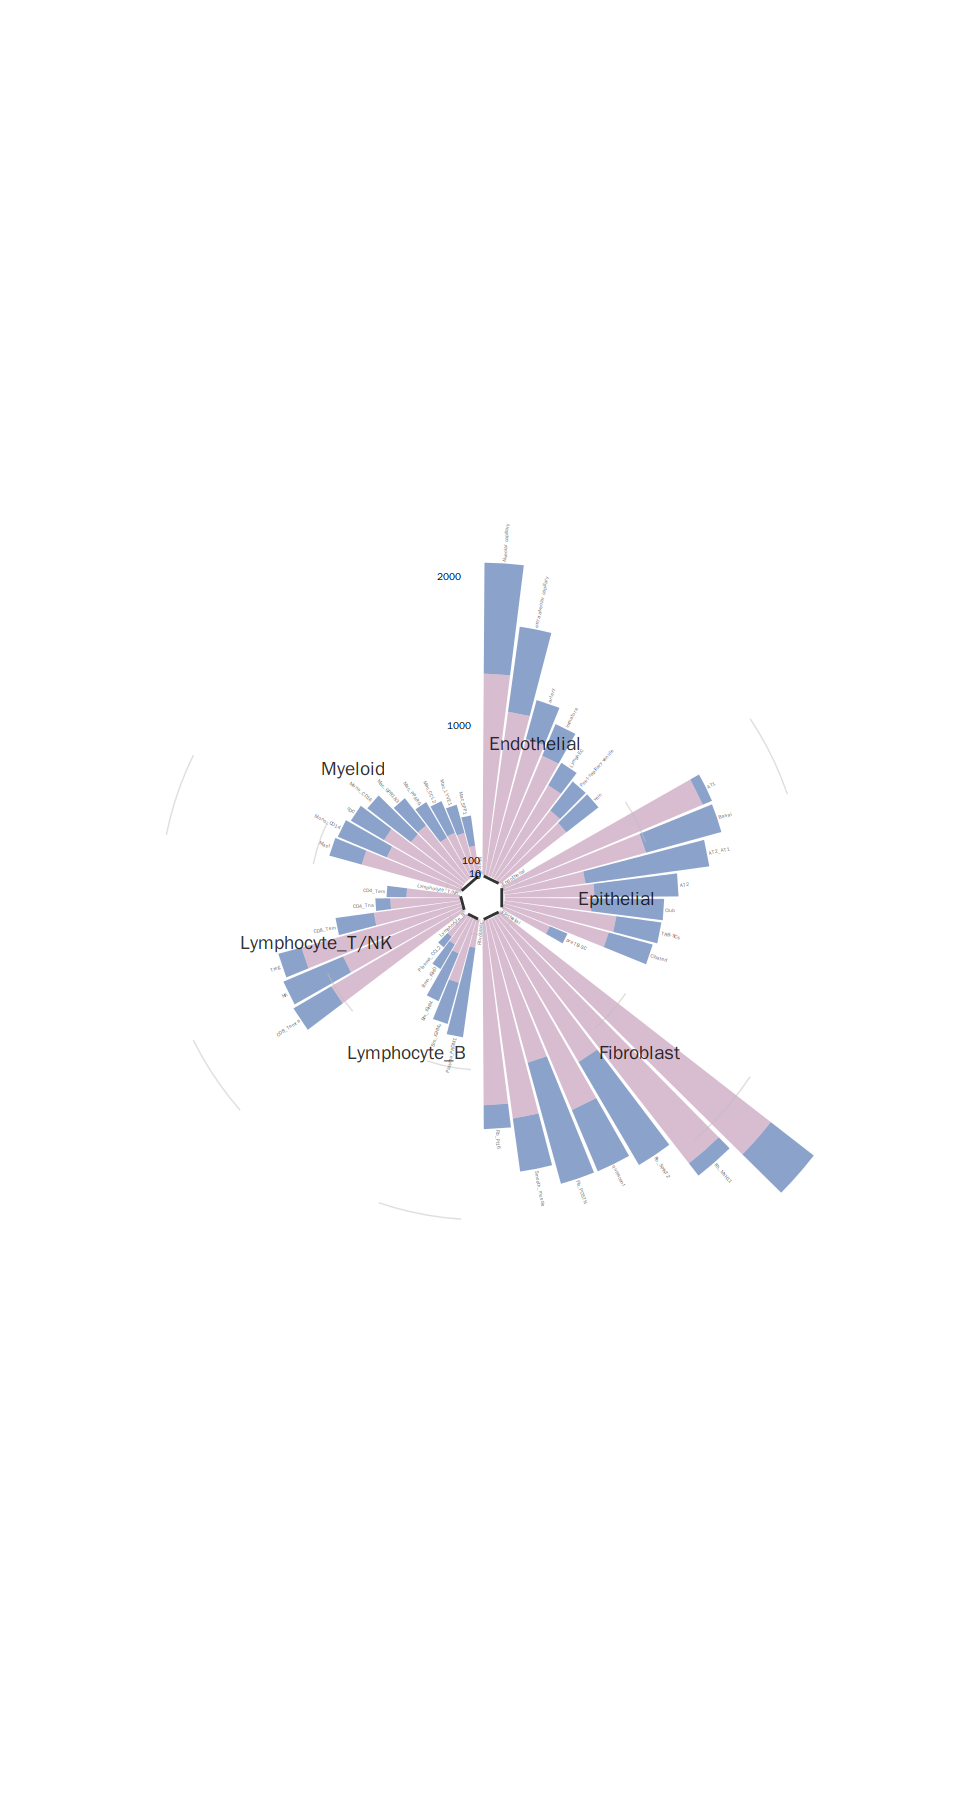

In [305]:
# # --- DEGs for each CellType with Circular bar plot
# ct.list <- immune.cluster@meta.data$ct_level2 %>% unique()
# data = NULL
# for(ct in ct.list){
#     print(ct)
#     immune <- immune.cluster %>% subset(ct_level2 == ct)
#     DefaultAssay(immune) <- 'RNA'
#     cell.ssc <- immune@meta.data %>% subset(Group == 'SSC') %>% rownames()
#     # Skip if the subset has no cells
#     if (length(cell.ssc) == 0) {
#         message("Skipping ", ct, " (no cells found)")
#         next
#     }
#     cell.hc <- immune@meta.data %>% subset(Group == 'HC') %>% rownames()
#     # Skip if the subset has no cells
#     if (length(cell.hc) == 0) {
#         message("Skipping ", ct, " (no cells found)")
#         next
#     }
#     diff <- FindMarkers(immune, min.pct = 0.01, logfc.threshold = 0.2, ident.1 = cell.ssc, ident.2 = cell.hc) %>% rownames_to_column(var = "gene")
#     diff$CellType <- ct
#     data <- rbind(data, diff)
# }
# saveRDS(data, 'DEGs_in_ct_level2.rds')

data <- readRDS('DEGs_in_ct_level2.rds')
data$CellType[which(data$CellType == 'Mac_FABP5')] <- 'Mac_SPP1'
ct.info <- immune.cluster@meta.data[,c('ct_level1', 'ct_level2')] %>% distinct() %>% {rownames(.) <- NULL; .} %>% dplyr::filter(ct_level2 != '')
nDeg.df <- data %>% 
                dplyr::filter(CellType != '') %>%
                dplyr::filter(p_val < 0.05) %>%
                mutate(Class = ifelse(avg_log2FC > 0, 'pos', 'neg'),
                      ct_level2 = CellType) %>%
                group_by(ct_level2, Class) %>% summarise(number = n()) %>%
                as.data.frame() %>%
                left_join(ct.info, by = 'ct_level2')

# Create empty bars
empty_bar <- 1  # Number of empty bars to insert
ct_levels <- unique(nDeg.df$ct_level1)
empty_pos <- data.frame(
  number = 0,
  Class = 'pos',
  ct_level1 = rep(ct_levels, each = empty_bar),
  ct_level2 = rep(ct_levels, each = empty_bar)
)
empty_neg <- data.frame(
  number = 0,
  Class = 'neg',
  ct_level1 = rep(ct_levels, each = empty_bar),
  ct_level2 = rep(ct_levels, each = empty_bar)
)
nDeg.df <- rbind(nDeg.df, empty_pos) %>% rbind(empty_neg)

# Arrange the bar order
empty_bar = 1
nObsType = nlevels(as.factor(nDeg.df$Class))
to_add = data.frame(matrix(NA, empty_bar*nlevels(nDeg.df$ct_level1)*nObsType, ncol(nDeg.df)) )
colnames(to_add) = colnames(nDeg.df)
to_add$ct_level1 = rep(levels(nDeg.df$ct_level1), each=empty_bar*nObsType )
nDeg.dfa = rbind(nDeg.df, to_add)
nDeg.df = nDeg.df %>% arrange(ct_level1, ct_level2, number)
total.degs <- nDeg.df %>% 
                    group_by(ct_level2) %>%
                    summarise(sumDegs = sum(number)) %>%
                    as.data.frame()
nDeg.df <- nDeg.df %>% left_join(total.degs, by = 'ct_level2') %>% arrange(ct_level1, desc(sumDegs))
nDeg.df$id = rep( seq(1, nrow(nDeg.df)/nObsType) , each=nObsType)

# Get the name and the y position of each label
label_nDeg.df = nDeg.df %>% group_by(id, ct_level2) %>% summarize(tot = sum(number))
number_of_bar = nrow(label_nDeg.df)
angle = 90 - 360 * (label_nDeg.df$id-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
label_nDeg.df$hjust <- ifelse( angle < -90, 1, 0)
label_nDeg.df$angle <- ifelse(angle < -90, angle+180, angle)
head(label_nDeg.df)

# prepare a nDeg.df frame for base lines
base_nDeg.df = nDeg.df %>% 
  group_by(ct_level1) %>% 
  summarize(start = min(id), end = max(id) - empty_bar) %>% 
  rowwise() %>% 
  mutate(title = mean(c(start, end)))
head(base_nDeg.df)

# prepare a nDeg.df frame for grid (scales)
grid_nDeg.df = base_nDeg.df
grid_nDeg.df$end = grid_nDeg.df$end[c(nrow(grid_nDeg.df), 1:nrow(grid_nDeg.df)-1)] + 1
grid_nDeg.df$start = grid_nDeg.df$start - 1
grid_nDeg.df = grid_nDeg.df[-1,]
head(grid_nDeg.df)

# Make the plot
ggplot(nDeg.df) +      
  
  # Add the stacked bar
  geom_bar(aes(x = as.factor(id), y = number, fill = Class), stat="identity", alpha=0.5) +
  # scale_fill_viridis(discrete=TRUE) +
  scale_fill_manual(values = c("#184995", "#B17AA1")) +
  # Add a val=100/75/50/25 lines. I do it at the beginning to make sur barplots are OVER it.
  geom_segment(data=grid_nDeg.df, aes(x = end+2, y = 0, xend = start, yend = 0), colour = "grey", alpha=0.5, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_nDeg.df, aes(x = end+2, y = 10, xend = start, yend = 10), colour = "grey", alpha=0.5, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_nDeg.df, aes(x = end+2, y = 100, xend = start, yend = 100), colour = "grey", alpha=0.5, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_nDeg.df, aes(x = end+2, y = 1000, xend = start, yend = 1000), colour = "grey", alpha=0.5, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_nDeg.df, aes(x = end+2, y = 2000, xend = start, yend = 2000), colour = "grey", alpha=0.5, size=0.3 , inherit.aes = FALSE ) +
  
  # Add text showing the value of each 100/75/50/25 lines
  annotate("text", x = rep(max(nDeg.df$id), 5), y = c(0, 10, 100, 1000, 2000), label = c("0", "10", "100", "1000", "2000") , color="black", size=2 , angle=0, fontface="bold", hjust=1) +
  
  ylim(-150,max(label_nDeg.df$tot, na.rm=T)) +
  theme_minimal() +
  theme(
    legend.position = "none",
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(rep(-1,4), "cm") 
  ) +
  coord_polar() +
  
  # Add labels on top of each bar
  geom_text(data=label_nDeg.df, aes(x=id, y=tot+10, label=ct_level2, hjust=hjust), color="black", fontface="bold",alpha=0.6, size=1, angle= label_nDeg.df$angle, inherit.aes = FALSE ) +
  
  # Add base line information
  geom_segment(data=base_nDeg.df, aes(x = start, y = -5, xend = end, yend = -5), colour = "black", alpha=0.8, size=0.6 , inherit.aes = FALSE ) +
  geom_text(data=base_nDeg.df, aes(x = title, y = 1000, label=ct_level1), hjust=c(0.75, 1, -0.5, 0.5, 0.5, 0.75), colour = "black", alpha=0.8, size=4, fontface="bold", inherit.aes = FALSE)
# ggsave('./figures/nDegs_CircularBar.pdf', width = 8, heigh = 8)

`summarise()` has grouped output by 'id'. You can override using the `.groups` argument.


id ct_level2                tot hjust angle
1 1  extra-alveolar capillary 21  0     86.25
2 2  artery                   20  0     78.75
3 3  vein                     17  0     71.25
4 4  Alveolar capillary       16  0     63.75
5 5  Post-capillary venule    15  0     56.25
6 6  immature                 15  0     48.75

ct_level1       start end title
1 Endothelial      1     7   4.0 
2 Epithelial       9    16  12.5 
3 Fibroblast      18    24  21.0 
4 Lymphocyte_B    26    30  28.0 
5 Lymphocyte_T/NK 32    37  34.5 
6 Myeloid         39    47  43.0

ct_level1       start end title
1 Epithelial       8     8  12.5 
2 Fibroblast      17    17  21.0 
3 Lymphocyte_B    25    25  28.0 
4 Lymphocyte_T/NK 31    31  34.5 
5 Myeloid         38    38  43.0

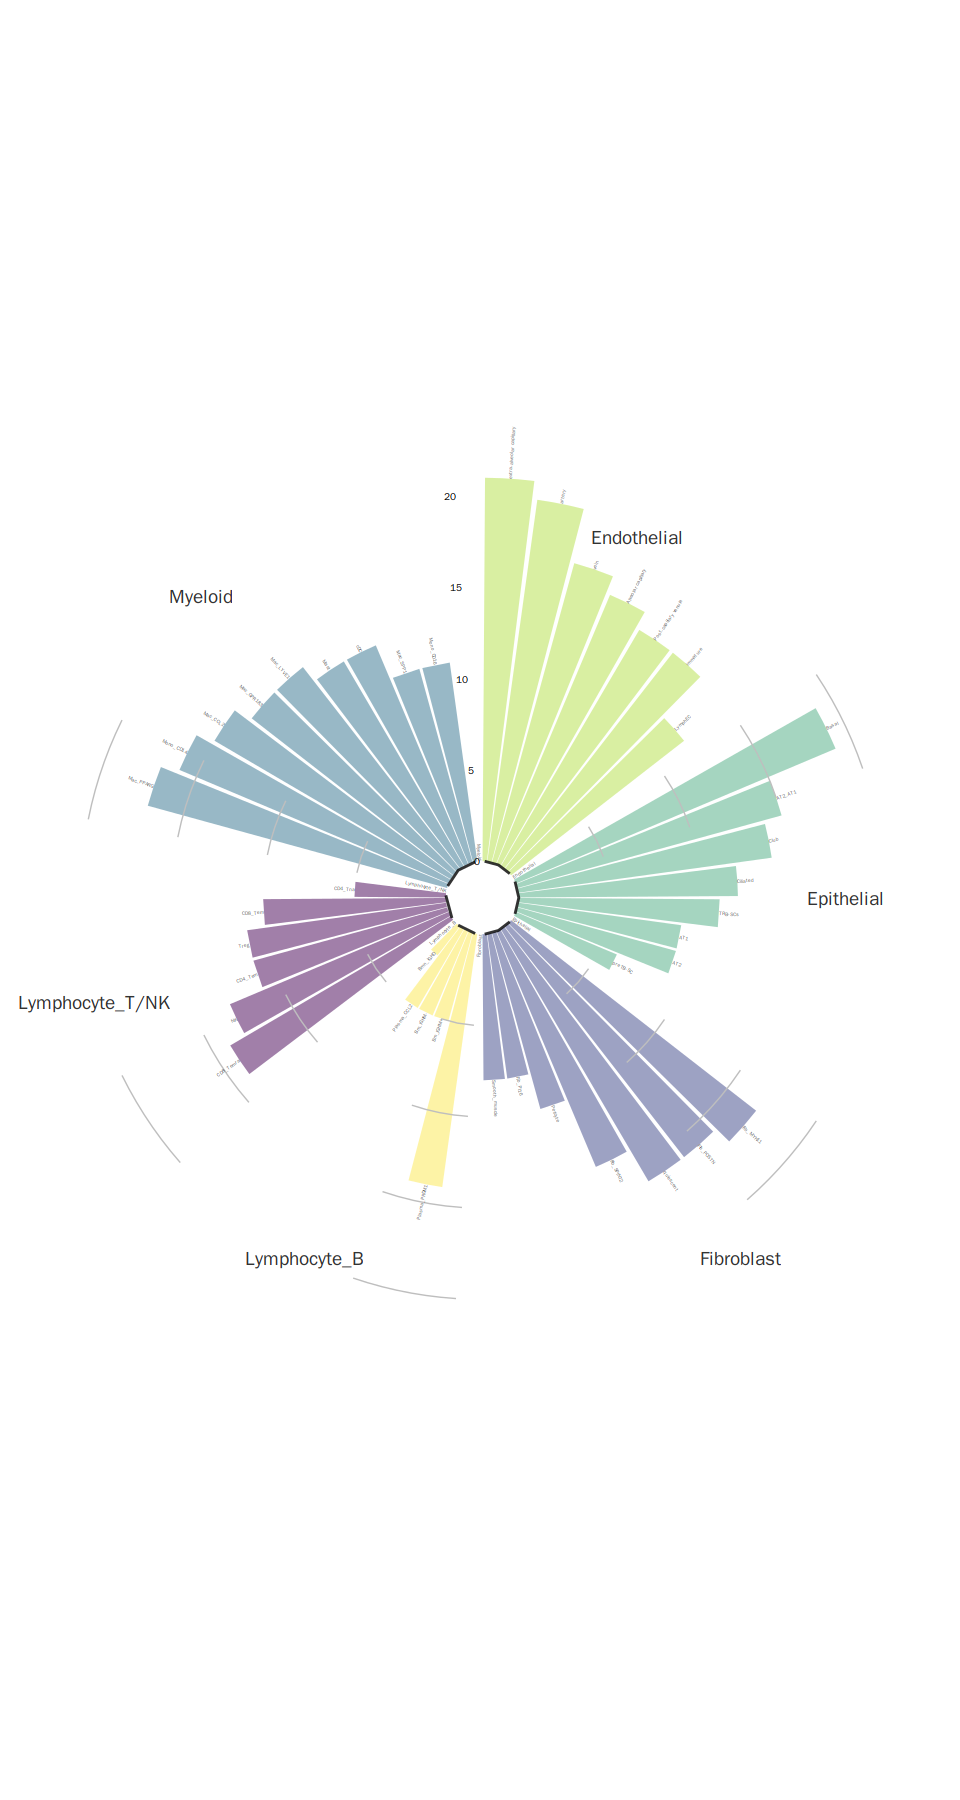

In [307]:
# --- SSc realted genes with CircularBarPlot
ssc.genes <- c(
    # --- https://pureadmin.qub.ac.uk/ws/files/387890502/Mediators_of_systemic.pdf     
    'ADAMTS13', 'IGF1', 'CAMP', 'SELL', 'TNF', 
   'CRP', 'CCL17', 'CCL2', 'CCL4', 'CCL18', 'CX3CL1', 'CXCL13', 'CXCL4', 'CXCL5', 'GREM1', 'HMGB1',
   'ICAM1', 'IGFBP2', 'IGFBP3', 'IL1B',  'IL4', 'IL6', 'IL7', 'IL8', 'IL10', 'IL12', 'IL17A', 'MUC1', 'LEP', 'MMP7', 'MMP9', 
   'SPP1', 'PPARG', 'RETN', 'SELE', 'SELP', 'SFTPA1', 'SFTPA2', 'SFTPD', 'TGFB1', 'SNAP47', 'VWF', 'DEFA1', 'DEFA1B', 'DEFA3','WFDC2',
   'S100A8', 'S100A9', 'TIMP1', 'TMSB4X',
    # --- https://www.nature.com/articles/s41467-023-44541-z (Data_S1 & Table2) #'DEKQ', TPI1P2-LOC407835
    'IL12RB2', 'FLG', 'CD247', 'NAB1', 'STAT4', 'PXK', 'ARHGAP31','IL12A-AS1', 'DGKQ', 'NFKB1', 'TNIP1', 'TNPO3', 'CDHR5', 'DDX6',
   'IGHM', 'CSK', 'GSDMA', 'GSDMB', 'NUP85', 'IL12RB1', 'TNFSF4', 'FLNB', 'TNFAIP3', 'ESR1', 'AHNAK2', 'SLC12A5', 
    'FAM167A','BLK', #'FAM167A-BLK'
   'RAB2A', 'CHD7', # 'RAB2A-CHD7',
    'TSPAN32', 'CD81-AS1', # 'TSPAN32-CD81-AS1',
    'IRF8', 'LINC01082', # 'IRF8-LINC01082',
    'PRDM1', 'ATG5', # 'PRDM1-ATG5'
    'KCP', 'IRF5', # KCP-IRF5
    'LINC01301', # LINC01301-RAB2A 
    # --- https://ard.bmj.com/content/annrheumdis/80/1/118.full.pdf  #'CAVIN2-AS1', 'DEGQ','FAM',  'VCF1'
    'GNG12', 'POU2F1', 'TNFSF4', 'FLNB', 'PXK', 'IGSF11', 'SCHIP1',  'LINC02428',
    'HLA-DQB1', 'LINC02532',  'FAM85B', 'ASPH', 'CDHR5', 'CD81-AS1', 'PHLDB1', 'SIN3A', 'TBC1D3C'
  ) %>% unique()

data <- readRDS('DEGs_in_ct_level2.rds') %>% dplyr::filter(gene %in% ssc.genes)
data$CellType[which(data$CellType == 'Mac_FABP5')] <- 'Mac_SPP1'
ct.info <- immune.cluster@meta.data[,c('ct_level1', 'ct_level2')] %>% distinct() %>% {rownames(.) <- NULL; .} %>% dplyr::filter(ct_level2 != '')
nDeg.df <- data %>% 
                dplyr::filter(CellType != '') %>%
                dplyr::filter(p_val < 0.05) %>%
                mutate(ct_level2 = CellType) %>%
                group_by(ct_level2) %>% summarise(number = n()) %>%
                as.data.frame() %>%
                left_join(ct.info, by = 'ct_level2')

# Create empty bars
empty_bar <- 1  # Number of empty bars to insert
ct_levels <- unique(nDeg.df$ct_level1)
empty <- data.frame(
  number = 0,
  ct_level1 = rep(ct_levels, each = empty_bar),
  ct_level2 = rep(ct_levels, each = empty_bar)
)
nDeg.df <- rbind(nDeg.df, empty)

# Arrange the bar order
empty_bar = 1
to_add = data.frame(matrix(NA, empty_bar*nlevels(nDeg.df$ct_level1)*nObsType, ncol(nDeg.df)) )
colnames(to_add) = colnames(nDeg.df)
to_add$ct_level1 = rep(levels(nDeg.df$ct_level1), each=empty_bar*nObsType )
nDeg.df = rbind(nDeg.df, to_add)
nDeg.df = nDeg.df %>% arrange(ct_level1, desc(number))
nDeg.df$id = rep(seq(1, nrow(nDeg.df)), each=1)

# Get the name and the y position of each label
label_nDeg.df = nDeg.df %>% group_by(id, ct_level2) %>% summarize(tot = sum(number))
number_of_bar = nrow(label_nDeg.df)
angle = 90 - 360 * (label_nDeg.df$id-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
label_nDeg.df$hjust <- ifelse( angle < -90, 1, 0)
label_nDeg.df$angle <- ifelse(angle < -90, angle+180, angle)
head(label_nDeg.df)

# prepare a nDeg.df frame for base lines
base_nDeg.df = nDeg.df %>% 
  group_by(ct_level1) %>% 
  summarize(start = min(id), end = max(id) - empty_bar) %>% 
  rowwise() %>% 
  mutate(title = mean(c(start, end)))
head(base_nDeg.df)

# prepare a nDeg.df frame for grid (scales)
grid_nDeg.df = base_nDeg.df
grid_nDeg.df$end = grid_nDeg.df$end[c(nrow(grid_nDeg.df), 1:nrow(grid_nDeg.df)-1)] + 1
grid_nDeg.df$start = grid_nDeg.df$start - 1
grid_nDeg.df = grid_nDeg.df[-1,]
head(grid_nDeg.df)

# Make the plot
ggplot(nDeg.df) +       
  # Add the stacked bar
  geom_bar(aes(x = as.factor(id), y = number, fill = ct_level1), stat="identity", alpha=0.5) +
  
  geom_segment(data=grid_nDeg.df, aes(x = end+2, y = 20, xend = start, yend = 20), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_nDeg.df, aes(x = end+2, y = 15, xend = start, yend = 15), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_nDeg.df, aes(x = end+2, y = 10, xend = start, yend = 10), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_nDeg.df, aes(x = end +2, y = 5, xend = start, yend = 5), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +

  scale_fill_manual(values = c('Epithelial' = "#4DAB81",
                              'Endothelial' = "#B4E046",
                              'Fibroblast' =  "#3D4787",
                              'Myeloid' =  "#32738E",
                              'Lymphocyte_B' = "#FBE84E",
                              'Lymphocyte_T/NK' = '#440154FF')) +
  # Add text showing the value of each 100/75/50/25 lines
  annotate("text", x = rep(max(nDeg.df$id), 5), y = c(0, 5, 10, 15, 20), label = c("0", "5", "10", "15", "20") , color="black", size=2 , angle=0, fontface="bold", hjust=1) +
  
  ylim(-2, max(label_nDeg.df$tot, na.rm=T)) +
  theme_minimal() +
  theme(
    legend.position = "none",
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(rep(-1,5), "cm") 
  ) +
  coord_polar() +
  
  # Add labels on top of each bar
  geom_text(data=label_nDeg.df, aes(x=id, y=tot, label=ct_level2, hjust=hjust), color="black", fontface="bold",alpha=0.6, size=1, angle= label_nDeg.df$angle, inherit.aes = FALSE ) +
  
  # Add base line information
  geom_segment(data=base_nDeg.df, aes(x = start, y = 0, xend = end, yend = 0), colour = "black", alpha=0.8, size=0.6 , inherit.aes = FALSE ) +
  geom_text(data=base_nDeg.df, aes(x = title, y = 20, label=ct_level1), hjust=c(0.75, 1, -0.5, 0.5, 0.5, 0.75), colour = "black", alpha=0.8, size=4, fontface="bold", inherit.aes = FALSE)
# ggsave('./figures/nSScDegs_CircularBar.pdf', width = 4, heigh = 4)

In [13]:
# # --- Arrange GWAS genes as table
# proj1 = c('ADAMTS13', 'IGF1', 'CAMP', 'SELL', 'TNF', 
#    'CRP', 'CCL17', 'CCL2', 'CCL4', 'CCL18', 'CX3CL1', 'CXCL13', 'CXCL4', 'CXCL5', 'GREM1', 'HMGB1',
#    'ICAM1', 'IGFBP2', 'IGFBP3', 'IL1B',  'IL4', 'IL6', 'IL7', 'IL8', 'IL10', 'IL12', 'IL17A', 'MUC1', 'LEP', 'MMP7', 'MMP9', 
#    'SPP1', 'PPARG', 'RETN', 'SELE', 'SELP', 'SFTPA1', 'SFTPA2', 'SFTPD', 'TGFB1', 'SNAP47', 'VWF', 'DEFA1', 'DEFA1B', 'DEFA3','WFDC2',
#    'S100A8', 'S100A9', 'TIMP1', 'TMSB4X')
# proj1.name = rep('PMID: 36261273
        
        
        
        ', times = length(proj1))
# proj2 = c('IL12RB2', 'FLG', 'CD247', 'NAB1', 'STAT4', 'PXK', 'ARHGAP31','IL12A-AS1', 'DGKQ', 'NFKB1', 'TNIP1', 'TNPO3', 'CDHR5', 'DDX6',
#    'IGHM', 'CSK', 'GSDMA', 'GSDMB', 'NUP85', 'IL12RB1', 'TNFSF4', 'FLNB', 'TNFAIP3', 'ESR1', 'AHNAK2', 'SLC12A5', 
#     'FAM167A','BLK', #'FAM167A-BLK'
#    'RAB2A', 'CHD7', # 'RAB2A-CHD7',
#     'TSPAN32', 'CD81-AS1', # 'TSPAN32-CD81-AS1',
#     'IRF8', 'LINC01082', # 'IRF8-LINC01082',
#     'PRDM1', 'ATG5', # 'PRDM1-ATG5'
#     'KCP', 'IRF5', # KCP-IRF5
#     'LINC01301')
# proj2.name = rep('PMID: 38296975
        
        
        
        ', times = length(proj2))
# proj3 = c('GNG12', 'POU2F1', 'TNFSF4', 'FLNB', 'PXK', 'IGSF11', 'SCHIP1',  'LINC02428',
#     'HLA-DQB1', 'LINC02532',  'FAM85B', 'ASPH', 'CDHR5', 'CD81-AS1', 'PHLDB1', 'SIN3A', 'TBC1D3C')
# proj3.name = rep('PMID: 33004331
        
        
        
        ', times = length(proj3))
data.frame(Gene = proj1 %>% append(proj2) %>% append(proj3),
          PMID = proj1.name %>% append(proj2.name) %>% append(proj3.name)) %>%
          write.csv('GWAS_SSc_Genes.csv', row.names = F)

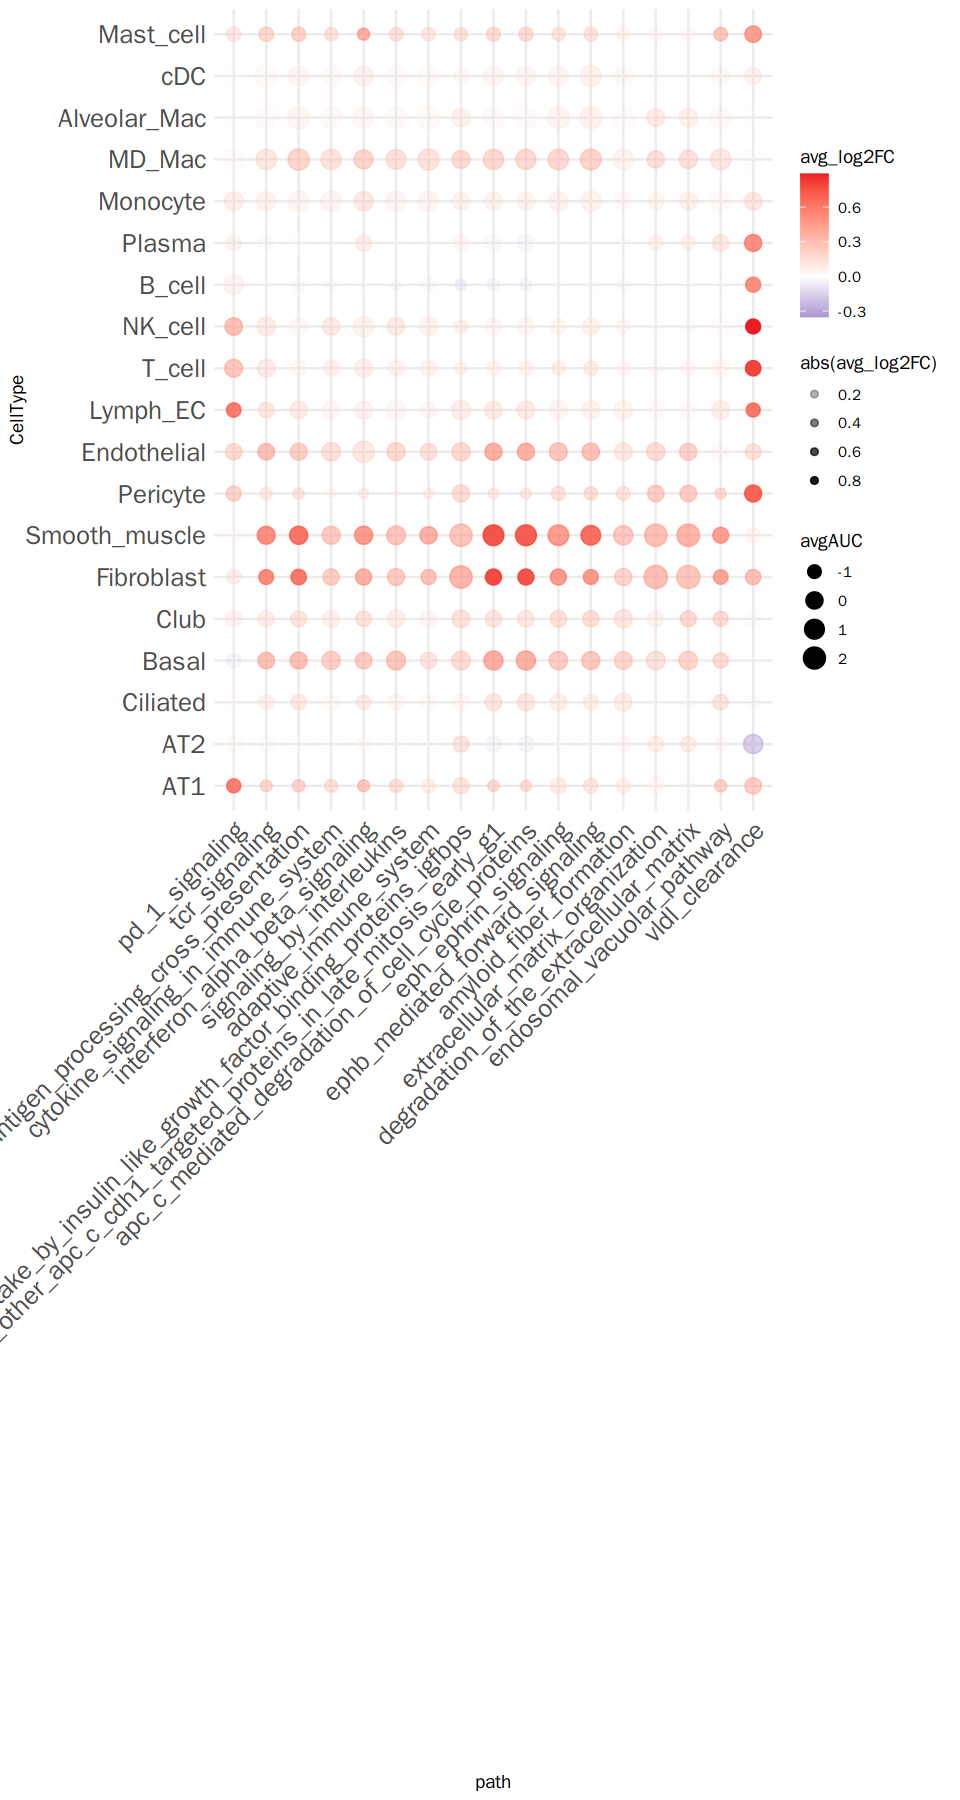

In [287]:
# --- Riched Reactome pathways in different CellType in SSc
# # --- Riched Reactome Pathways among ct_level1
# immune.cluster.f <- subset(immune.cluster, Cohort %in% c('ev', 'paul'))
# ct.list <- immune.cluster.f@meta.data$CellType %>% unique()
# data = NULL
# for(ct in ct.list){
#     print(ct)
#     immune <- immune.cluster.f %>% subset(CellType == ct)
#     DefaultAssay(immune) <- 'AUC'
#     cell.ssc <- immune@meta.data %>% subset(Group == 'SSC') %>% rownames()
#     # Skip if the subset has no cells
#     if (length(cell.ssc) == 0) {
#         message("Skipping ", ct, " (no cells found)")
#         next
#     }
#     cell.hc <- immune@meta.data %>% subset(Group == 'HC') %>% rownames()
#     # Skip if the subset has no cells
#     if (length(cell.hc) == 0) {
#         message("Skipping ", ct, " (no cells found)")
#         next
#     }
#     diff <- FindMarkers(immune, min.pct = 0.01, logfc.threshold = 0, ident.1 = cell.ssc, ident.2 = cell.hc, pseudocount.use = 0.0001) %>% 
#                 rownames_to_column(var = "path")
#     diff$CellType <- ct
#     data <- rbind(data, diff)
# }
# saveRDS(data, 'DEAUCs_in_CellType.rds')
auc.df <- readRDS('DEAUCs_in_CellType.rds')
ct.list <- c('AT1', 'AT2', 'Ciliated', 'Basal', 'Club', 
             'Fibroblast', 'Smooth_muscle', 'Pericyte', 'Endothelial', 'Lymph_EC',
             'T_cell', 'NK_cell', 'B_cell', 'Plasma', 
             'Monocyte', 'MD_Mac', 'Alveolar_Mac', 'cDC', 'Mast_cell' )

# --- screen increased AUC pathways among CellType
auc.df$path <- auc.df$path %>% tolower() %>% gsub('reactome-', '', .) %>% gsub('-', '_', .)
ol.path <- auc.df %>% dplyr::filter(p_val < 0.001, avg_log2FC > 0) %>%
            group_by(CellType) %>% arrange(p_val) %>% slice_head(n = 35) %>%
            ungroup() %>%
            group_by(path) %>% summarise(nn = n()) %>% arrange(-nn) %>% 
            dplyr::filter(nn >= 5) %>% pull(path)
path.order <- c(# --- inflammatory
                'pd_1_signaling',                
                'tcr_signaling', 
                'antigen_processing_cross_presentation', 
                'cytokine_signaling_in_immune_system', 
                'interferon_alpha_beta_signaling',           
                'signaling_by_interleukins',
                'adaptive_immune_system', 
                # --- Proliferation
                'regulation_of_insulin_like_growth_factor_igf_transport_and_uptake_by_insulin_like_growth_factor_binding_proteins_igfbps',  
                'apc_c_cdh1_mediated_degradation_of_cdc20_and_other_apc_c_cdh1_targeted_proteins_in_late_mitosis_early_g1', 
                'apc_c_mediated_degradation_of_cell_cycle_proteins', 
                # --- Firbosis
                'eph_ephrin_signaling', 
                'ephb_mediated_forward_signaling',
                'amyloid_fiber_formation', 
                'extracellular_matrix_organization', 
                'degradation_of_the_extracellular_matrix', 
                
                'endosomal_vacuolar_pathway', 
                'vldl_clearance')
df <- auc.df %>% dplyr::filter(path %in% path.order)

# --- AUC score in each CellType
immune.cluster@meta.data <- immune.cluster@meta.data %>% mutate(Group_CT = paste0(Group, '|', CellType))
DefaultAssay(immune.cluster) <- 'AUC'
sam.avg <- AverageExpression(immune.cluster, assays = 'AUC', group.by = 'CellType')
auc.df <- sam.avg$AUC %>% as.data.frame() %>% rownames_to_column(var = 'path')
auc.df$path <- auc.df$path %>% tolower() %>% gsub('reactome-', '', .) %>% gsub('-', '_', .)
auc.df2.score <- auc.df %>% column_to_rownames(var = 'path') %>% t() %>% 
                    scale(scale = TRUE, center = TRUE) %>% as.data.frame() %>% 
                    rownames_to_column(var = 'CellType') %>% as.data.frame() %>%
                    pivot_longer(!CellType, names_to = 'path', values_to = 'avgAUC') %>% 
                    mutate(ID = paste(CellType, path))

df.p <- df %>% mutate(ID = paste(CellType, path)) %>%
            left_join(auc.df2.score[,c('ID', 'avgAUC')], by = 'ID')

options(repr.plot.height = 15, repr.plot.width = 8)
df.p$CellType <- factor(df.p$CellType, levels = ct.list)
df.p$path <- factor(df.p$path, levels = path.order)
df.p %>% 
    ggplot(aes(path, CellType)) + 
    geom_point(aes(size = avgAUC, alpha = abs(avg_log2FC), color = avg_log2FC)) + 
    scale_color_gradient2(low="darkblue",mid = 'white',high = "#ED1C24") +
    theme_minimal() +
     # theme(axis.text.x = element_blank(), axis.text.y = element_blank())
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size=15), axis.text.y = element_text(size=15)) 
# ggsave('./figures/DotPlot_AUC_pathways.pdf', width = 6, height = 4)

In [16]:
de.auc <- readRDS('DEAUCs_in_CellType.rds')
de.auc %>% write.csv('Figure1.h.csv', row.names = F)

In [68]:
# # --- Create Scoupe_Loom file
# library(SCopeLoomR)
# library(hdf5r)
# immune <- immune.cluster
# # --- 01 Create a loom file
# build_loom(file.name = "immune.loom",
#         dgem = immune@assays$RNA@counts,
#         title = "lung-all",
#         default.embedding = immune@reductions$umap@cell.embeddings,
#         default.embedding.name = "umap.rna")

# loom <- open_loom("immune.loom", mode = "r+")
# # --- 02 Add hierachy
# add_hierarchy(
#   loom = loom,
#   hierarchy = create_hierarchy(
#     level.1.name = "SSc-ILD",
#     level.2.name = "Lung-all"
#   )
# )
# # --- 03 Add embedding(s)
# add_embedding(loom = loom, 
#               embedding = immune@reductions$pca@cell.embeddings,
#               name = "pca")

# # --- 04 Add MetaDate
# names(loom[["col_attrs"]])
# add_col_attr(loom = loom, key = "Sample", value = immune@meta.data$SampleID, as.annotation = TRUE)
# add_col_attr(loom = loom, key = "Group", value = immune@meta.data$Group, as.annotation = TRUE)
# add_col_attr(loom = loom, key = "Site", value = immune@meta.data$Tissue, as.annotation = TRUE)
# add_col_attr(loom = loom, key = "Age", value = immune@meta.data$Age, as.metric = TRUE)
# add_col_attr(loom = loom, key = "Gender", value = immune@meta.data$Gender, as.annotation = TRUE)
# add_col_attr(loom = loom, key = "Cohort", value = immune@meta.data$Cohort, as.annotation = TRUE)

# immune@meta.data$CellType <- as.character(immune@meta.data$CellType)
# add_col_attr(loom = loom, key = "CellType", value = immune@meta.data$CellType, as.annotation = TRUE)

# names(loom[["col_attrs"]])

# # --- 05 Add Seurat clusters and markers
# add_seurat_clustering(loom = loom,
#         seurat = immune,
#         seurat.assay = "RNA",
#         seurat.clustering.prefix = "celltype.res.",
#         seurat.markers.file.path.list = list(celltype.res.0.1 = './SnnGenes/lung_ct_res.0.1.rds.gz'), 
#         seurat.marker.metric.accessors = c("avg_log2FC", "p_val"),
#         seurat.marker.metric.names = c("Avg. log2FC", "P-value"),
#         seurat.marker.metric.description = 
#           c("Average log fold change", "Adjusted p-value (BF)")
# )

# # --- 06 save loom file
# close_loom(loom)

An object of class Seurat 
51056 features across 71918 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

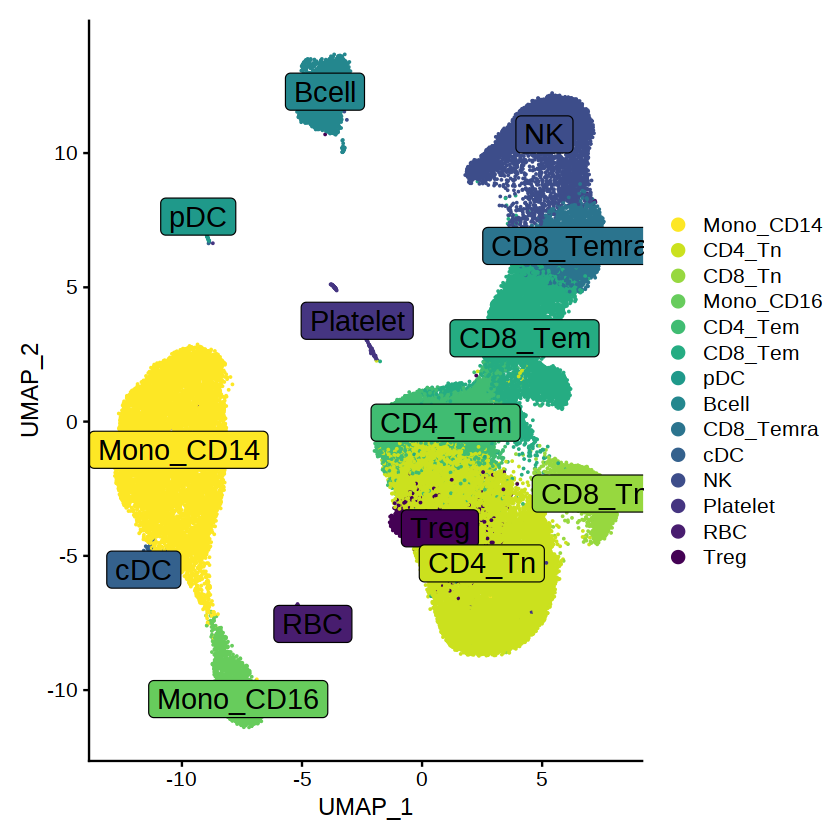

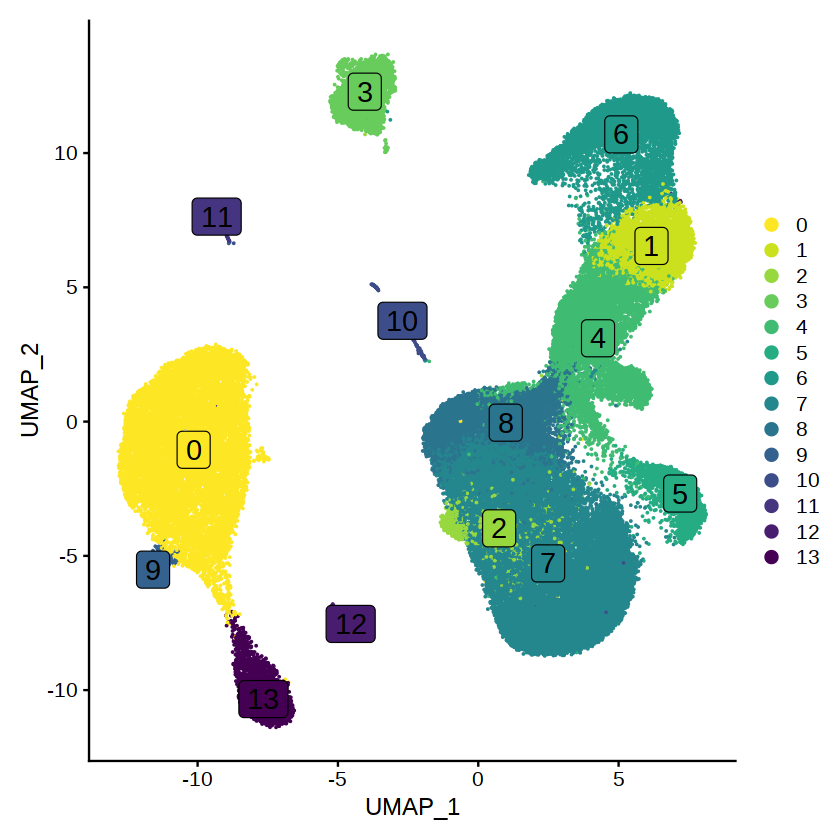

In [2]:
# #----------PBMC----------------
# immune.cluster <- readRDS("/share/home/qlab/projects/qlab_yrs/project_ssc/data/pbmc/object/anno_SSC_filter.rds")
# immune.cluster@meta.data  <- immune.cluster@meta.data %>% mutate(Sample = Subject)
# immune.cluster@meta.data$CellType[which(immune.cluster@meta.data$CellType == 'Megakaryocyte')] <- 'Platelet'
# immune.cluster@meta.data$CellType[which(immune.cluster@meta.data$CellType == 'B_cell')] <- 'Bcell'
# ct.res <- data.frame(CellType = immune.cluster@meta.data$CellType %>% as.character() %>% unique(),
#                      celltype.res.0.1 = 0:(length(immune.cluster@meta.data$CellType %>% as.character() %>% unique()) - 1))
# meta <- immune.cluster@meta.data
# immune.cluster@meta.data <- meta %>% 
#                                 rownames_to_column(var = 'cell') %>%
#                                 left_join(ct.res, by = 'CellType') %>%
#                                 column_to_rownames(var = 'cell')
# saveRDS(immune.cluster, 'ssc_pbmc_allCT.rds')
# DefaultAssay(immune.cluster) <- 'RNA'
# Idents(immune.cluster) <- 'celltype.res.0.1'
# markers <- FindAllMarkers(immune.cluster, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
# saveRDS(markers, file = paste0('./SnnGenes/pbmc_ct_res.0.1.rds.gz'), compress = "gzip")
# immune.cluster@meta.data$Cohort <- 'cl'
# immune.cluster@meta.data$Cohort[which(immune.cluster@meta.data$Sample == 'jxue')] <- 'jxue'
# immune.cluster@meta.data$Age[which(immune.cluster@meta.data$Sample == 'jxue')] <- '54'
# immune.cluster@meta.data$Tissue <- 'pbmc'
# immune.cluster@meta.data$Age[which(immune.cluster@meta.data$Sample == 'CHI014')] <- 'unknow'
# immune.cluster@meta.data$Gender[which(immune.cluster@meta.data$Sample == 'CHI014')] <- 'unknow'
# saveRDS(immune.cluster, 'ssc_pbmc_allCT2.rds')

immune.cluster <- readRDS('ssc_pbmc_allCT2.rds')
immune.cluster
order_list <- c('Mono_CD14', 'CD4_Tn', 'CD8_Tn',
                'Mono_CD16', 'CD4_Tem', 'CD8_Tem',
                'pDC', 'Bcell', 'CD8_Temra',
                'cDC', 'NK', 'Platelet','RBC', 'Treg')
immune.cluster.order <- immune.cluster
immune.cluster.order@meta.data$CellType <- factor(immune.cluster.order@meta.data$CellType, levels = order_list)
# pdf(file="./figures/PBMC_CellType_label.pdf",width=7)
Idents(immune.cluster.order) <- 'CellType'
DimPlot(immune.cluster.order, reduction = "umap", label = TRUE, label.size = 6, label.box = TRUE, raster = FALSE, cols=rev(viridis_pal()(14))) 
# dev.off()

Idents(immune.cluster.order) <- 'celltype.res.0.1'
DimPlot(immune.cluster.order, reduction = "umap", label = TRUE, label.size = 6, label.box = TRUE, raster = FALSE, cols=rev(viridis_pal()(14))) 

In [28]:
immune.cluster@meta.data$CellType %>% unique()
immune.cluster@meta.data$CellType %>% unique() %>% length() # 'CD4_Temra''CD8_Tmait'（T——subtype）'B_naive''B_memory''IgA_immature'（B-subtype）

[1] "Mono_CD14" "CD8_Temra" "Treg"      "Bcell"     "CD8_Tem"   "CD8_Tn"   
 [7] "NK"        "CD4_Tn"    "CD4_Tem"   "cDC"       "Platelet"  "pDC"      
[13] "RBC"       "Mono_CD16"

[1] 14

In [4]:
pdf(file="./figures/CellType.pdf",width=8)
immune.cluster.order@meta.data$CellType <- factor(immune.cluster@meta.data$CellType, levels = order_list)
DimPlot(immune.cluster.order, reduction = "umap",label = FALSE, group.by = "CellType", cols=rev(viridis_pal()(14))) + NoLegend()
dev.off()

png 
  2

In [25]:
# --- Extract Sample Information
meta  <- immune.cluster@meta.data 
immune.cluster@meta.data[,c('Sample','Group','Subject','Gender','Age')] %>% distinct() %>% {rownames(.) <- NULL; {.}} %>%
write.csv('pbmc_sample_info.csv')

In [15]:
# # --- Vln Plots
# DefaultAssay(immune.cluster.order) <- 'RNA'
# # pdf(file='./figures/Features.pdf',width=8)
# VlnPlot(immune.cluster.order, features = c("CD3E","CD4","LEF1","GZMA","FOXP3","CD8A","GZMK","GZMB","FCN1","FCGR3A","FCGR3B","CD79A",
#                                            "LILRA4","CD1C","PF4","HBB"), 
#         slot = "data",stack=TRUE, flip = T, adjust = 2, group.by = 'CellType',cols = viridis(16, option = "G"))
# # dev.off()

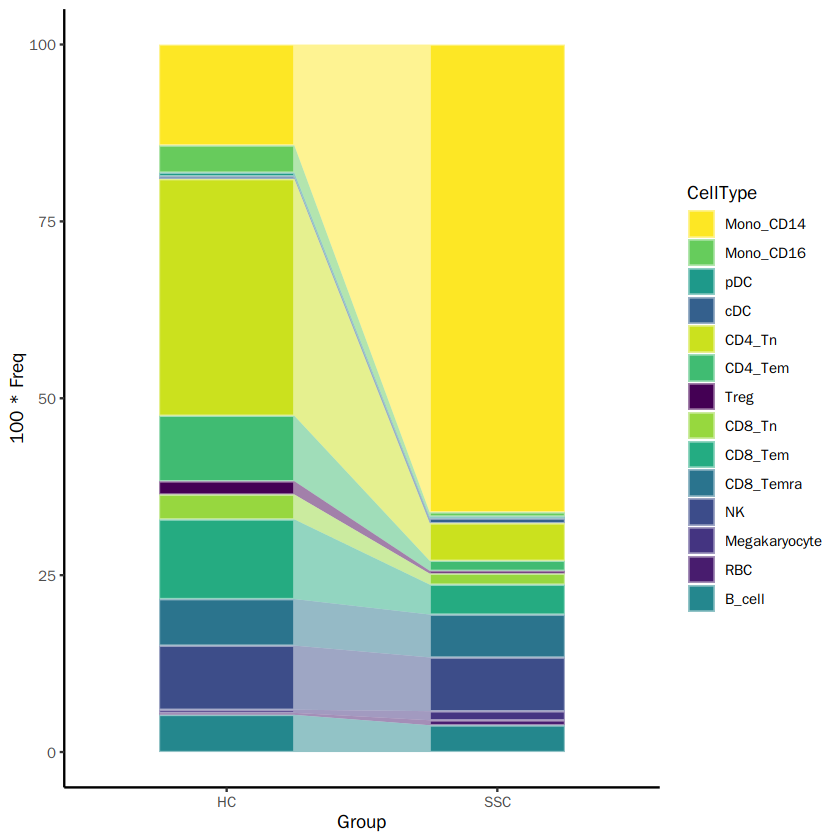

In [6]:
#----------堆积柱状图，含连线--------------------
tab.sample <- table(immune.cluster.order$Group,immune.cluster.order$CellType) %>% proportions(1) %>% as.data.frame()
colnames(tab.sample) <- c("Group","CellType","Freq")
ct.list <- c('Mono_CD14','Mono_CD16','pDC','cDC','CD4_Tn','CD4_Tem','Treg','CD8_Tn','CD8_Tem','CD8_Temra','NK','Megakaryocyte','RBC','B_cell')
col.list <- c('#FDE725FF','#67CC5CFF','#1F998AFF','#34618DFF','#CBE11EFF','#40BC72FF','#440154FF','#97D83FFF','#25AC82FF','#2B748EFF','#3D4D8AFF','#453581FF','#481D6FFF','#24878EFF')

tab.sample$CellType <- factor(tab.sample$CellType, levels=ct.list)

ggplot(tab.sample, aes(x = Group,y=100 * Freq,fill = CellType, colors(col.list), stratum = CellType, alluvium = CellType))+
    geom_stratum(width = 0.5, color='white')+
    geom_alluvium(alpha = 0.5, width = 0.5, curve_type = "linear")+
    scale_fill_manual(values=col.list) +
    theme_classic()
# ggsave('figures/pbmc_CT_stack_HCvsSSC.pdf',width=5)

In [78]:
# # --- Create Scoupe_Loom file
# library(SCopeLoomR)
# library(hdf5r)
# immune <- readRDS('ssc_pbmc_allCT2.rds')
# # --- 01 Create a loom file
# build_loom(file.name = "pbmc_immune.loom",
#         dgem = immune@assays$RNA@counts,
#         title = "pbmc",
#         default.embedding = immune@reductions$umap@cell.embeddings,
#         default.embedding.name = "umap.rna")

# loom <- open_loom("pbmc_immune.loom", mode = "r+")
# # --- 02 Add hierachy
# add_hierarchy(
#   loom = loom,
#   hierarchy = create_hierarchy(
#     level.1.name = "SSc-ILD",
#     level.2.name = "PBMC-all"
#   )
# )
# # --- 03 Add embedding(s)
# add_embedding(loom = loom, 
#               embedding = immune@reductions$pca@cell.embeddings,
#               name = "pca")

# # --- 04 Add MetaDate
# names(loom[["col_attrs"]])
# add_col_attr(loom = loom, key = "Sample", value = immune@meta.data$Sample, as.annotation = TRUE)
# add_col_attr(loom = loom, key = "Group", value = immune@meta.data$Group, as.annotation = TRUE)
# add_col_attr(loom = loom, key = "Site", value = immune@meta.data$Tissue, as.annotation = TRUE)
# add_col_attr(loom = loom, key = "Age", value = immune@meta.data$Age, as.annotation = TRUE)
# add_col_attr(loom = loom, key = "Gender", value = immune@meta.data$Gender, as.annotation = TRUE)
# add_col_attr(loom = loom, key = "Cohort", value = immune@meta.data$Cohort, as.annotation = TRUE)

# immune@meta.data$CellType <- as.character(immune@meta.data$CellType)
# add_col_attr(loom = loom, key = "CellType", value = immune@meta.data$CellType, as.annotation = TRUE)

# names(loom[["col_attrs"]])

# # --- 05 Add Seurat clusters and markers
# add_seurat_clustering(loom = loom,
#         seurat = immune,
#         seurat.assay = "RNA",
#         seurat.clustering.prefix = "celltype.res.",
#         seurat.markers.file.path.list = list(celltype.res.0.1 = './SnnGenes/pbmc_ct_res.0.1.rds.gz'),
#         seurat.marker.metric.accessors = c("avg_log2FC", "p_val"),
#         seurat.marker.metric.names = c("Avg. log2FC", "P-value"),
#         seurat.marker.metric.description = 
#           c("Average log fold change", "Adjusted p-value (BF)")
# )

# # --- 06 save loom file
# close_loom(loom)